✅ Données MNIST chargées:
   - Images d'entraînement: 60000
   - Images de test: 10000
   - Taille des images: 28x28


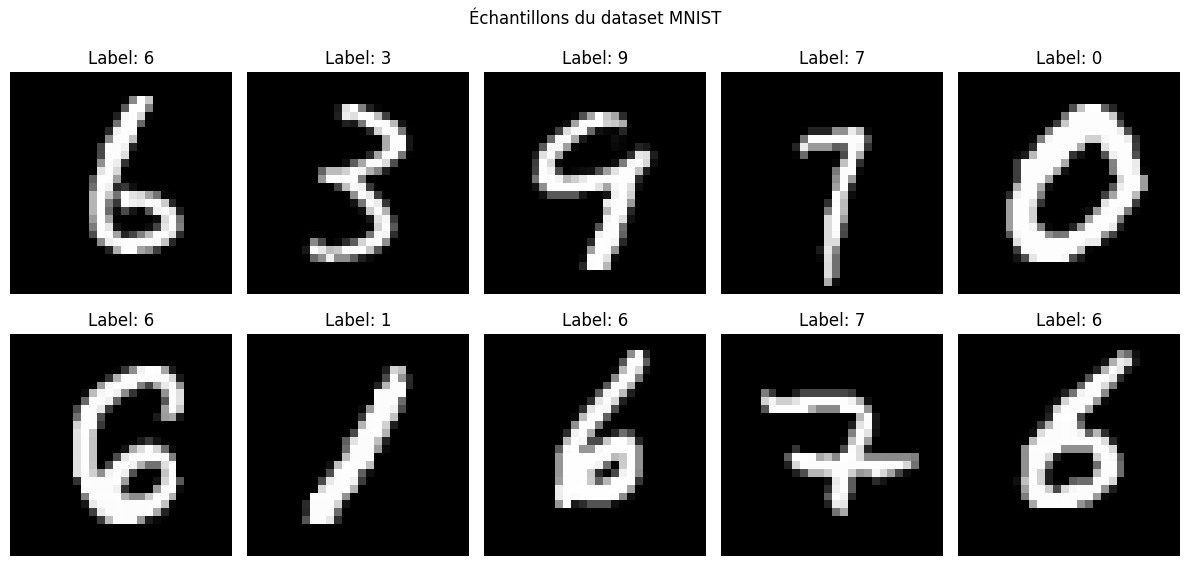

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
from os.path import join
import struct
from array import array

# Configuration des graphiques
%matplotlib inline
plt.style.use('default')

# Classe de chargement des données MNIST
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

# Chargement des données
input_path = '../../data/MNIST_Dataset'
training_images_filepath = join(input_path, "train-images.idx3-ubyte")
training_labels_filepath = join(input_path, "train-labels.idx1-ubyte")
test_images_filepath = join(input_path, "t10k-images.idx3-ubyte")
test_labels_filepath = join(input_path, "t10k-labels.idx1-ubyte")

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                  test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

print(f"✅ Données MNIST chargées:")
print(f"   - Images d'entraînement: {len(x_train)}")
print(f"   - Images de test: {len(x_test)}")
print(f"   - Taille des images: {x_train[0].shape if hasattr(x_train[0], 'shape') else '28x28'}")

# Affichage de quelques exemples
def show_sample_images(images, labels, n_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(n_samples):
        idx = random.randint(0, len(images) - 1)
        img = np.array(images[idx]) if isinstance(images[idx], list) else images[idx]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {labels[idx]}')
        axes[i].axis('off')

    plt.suptitle('Échantillons du dataset MNIST')
    plt.tight_layout()
    plt.show()

show_sample_images(x_train, y_train)

🎯 DÉMONSTRATION: VISUALISATION DES PROTOTYPES SOM
1️⃣ Préparation des données...

2️⃣ Création et entraînement de la SOM...
🗺️ SOM Visualizer initialisée:
   - Taille de la carte: 10×10
   - Nombre de prototypes: 100
   - Dimension d'entrée: 784
🏋️ Début de l'entraînement SOM:
   - Échantillons: 1000
   - Époques: 80
   - Taux d'apprentissage: 0.1
   - Sigma initial: 3.0


Entraînement: 100%|██████████| 80/80 [00:31<00:00,  2.56it/s, Error=1613438.6, LR=0.001]


✅ Entraînement terminé!
   - Erreur finale: 1613438.6
   - Amélioration: 1302015.7

3️⃣ Visualisation des prototypes...
🎨 Visualisation des prototypes (10×10)


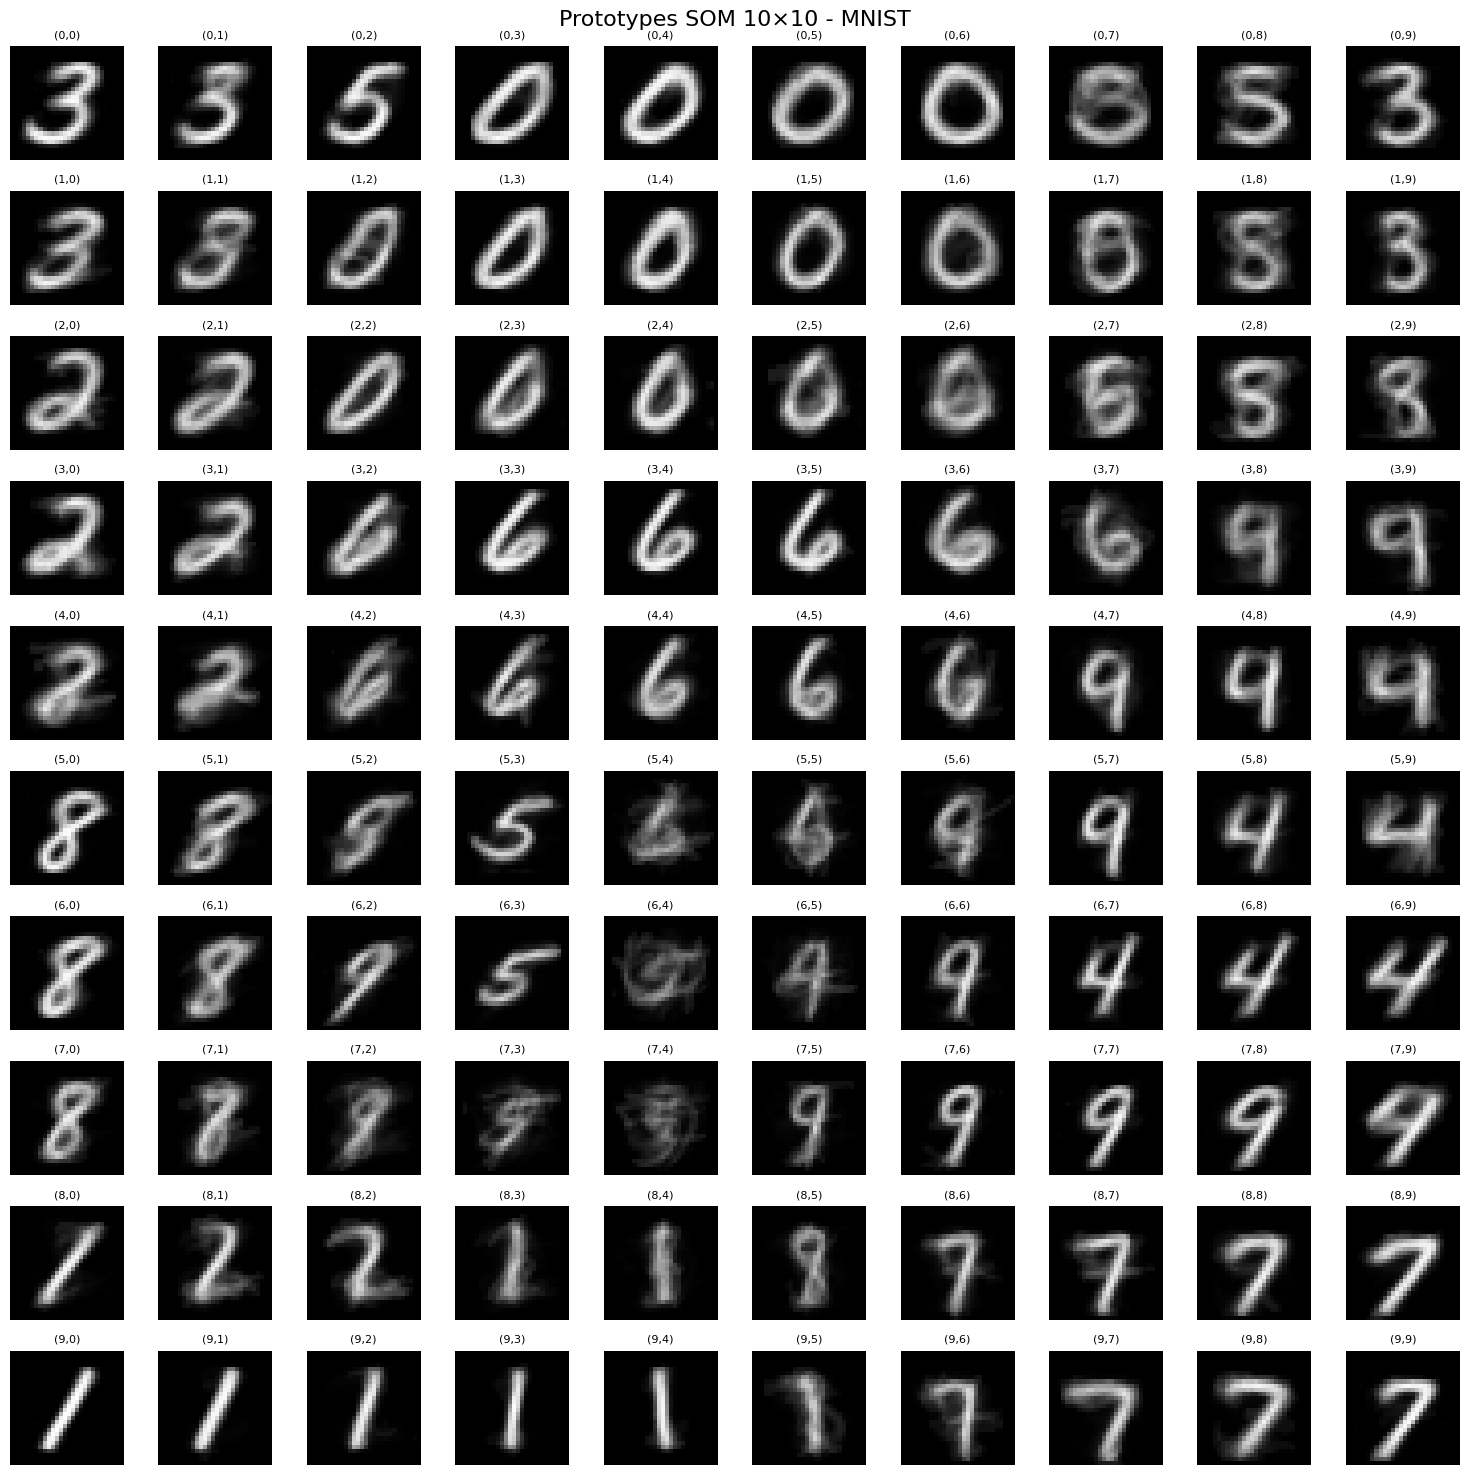

✅ Visualisation terminée!

4️⃣ Analyse de l'entraînement...


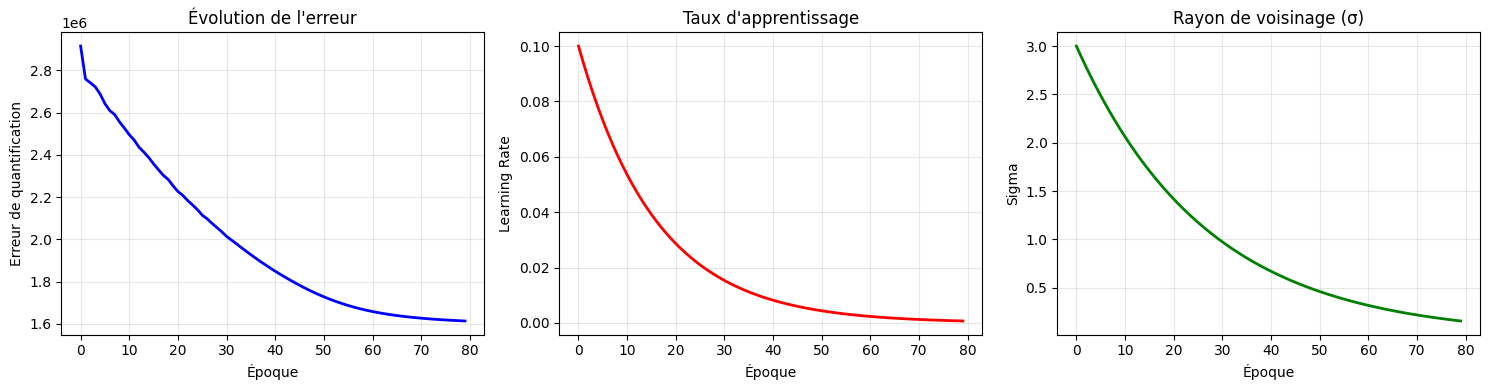


5️⃣ Analyse des prototypes...
📊 Analyse des prototypes:
Valeurs des prototypes:
   - Min: 0.0
   - Max: 253.3
   - Moyenne: 33.1
   - Écart-type: 59.2

Diversité des prototypes:
   - Luminosité moyenne min: 17.2
   - Luminosité moyenne max: 49.1
   - Écart-type des moyennes: 7.9

Positions remarquables:
   - Prototype le plus sombre: (np.int64(9), np.int64(3))
   - Prototype le plus clair: (np.int64(0), np.int64(4))


In [16]:
class SOM_Visualizer:
    """
    Self-Organizing Map 10×10 optimisée pour la visualisation des prototypes
    """

    def __init__(self, map_size=(10, 10), input_dim=784):
        """
        Initialise une carte SOM pour MNIST
        
        Args:
            map_size: Tuple (hauteur, largeur) de la carte
            input_dim: Dimension des données d'entrée (784 pour MNIST)
        """
        self.map_height, self.map_width = map_size
        self.input_dim = input_dim

        # Initialisation aléatoire des prototypes
        self.prototypes = np.random.uniform(0, 255, (self.map_height, self.map_width, self.input_dim))
        
        # États d'entraînement
        self.is_trained = False
        self.training_errors = []
        self.training_history = []

        print(f"🗺️ SOM Visualizer initialisée:")
        print(f"   - Taille de la carte: {self.map_height}×{self.map_width}")
        print(f"   - Nombre de prototypes: {self.map_height * self.map_width}")
        print(f"   - Dimension d'entrée: {self.input_dim}")

    def _find_bmu(self, input_vector):
        """
        Trouve le Best Matching Unit (BMU) - neurone le plus proche
        
        Args:
            input_vector: Vecteur d'entrée (784 dimensions)
            
        Returns:
            Tuple (i, j) des coordonnées du BMU
        """
        distances = np.zeros((self.map_height, self.map_width))

        for i in range(self.map_height):
            for j in range(self.map_width):
                diff = self.prototypes[i, j] - input_vector
                distances[i, j] = np.linalg.norm(diff)

        return np.unravel_index(np.argmin(distances), distances.shape)

    def _gaussian_neighborhood(self, bmu_pos, sigma):
        """
        Calcule la fonction de voisinage gaussienne
        
        Args:
            bmu_pos: Position du BMU (i, j)
            sigma: Rayon du voisinage
            
        Returns:
            Matrice de voisinage gaussienne
        """
        bmu_i, bmu_j = bmu_pos
        neighborhood = np.zeros((self.map_height, self.map_width))

        for i in range(self.map_height):
            for j in range(self.map_width):
                distance_sq = (i - bmu_i)**2 + (j - bmu_j)**2
                neighborhood[i, j] = np.exp(-distance_sq / (2 * sigma**2))

        return neighborhood

    def train(self, training_data, epochs=100, initial_learning_rate=0.1, initial_sigma=3.0, verbose=True):
        """
        Entraîne la carte SOM
        
        Args:
            training_data: Données d'entraînement (images aplaties)
            epochs: Nombre d'époques d'entraînement
            initial_learning_rate: Taux d'apprentissage initial
            initial_sigma: Rayon initial du voisinage
            verbose: Affichage des informations d'entraînement
        """
        if verbose:
            print(f"🏋️ Début de l'entraînement SOM:")
            print(f"   - Échantillons: {len(training_data)}")
            print(f"   - Époques: {epochs}")
            print(f"   - Taux d'apprentissage: {initial_learning_rate}")
            print(f"   - Sigma initial: {initial_sigma}")

        n_samples = len(training_data)
        self.training_errors = []
        self.training_history = []

        # Barre de progression
        progress_bar = tqdm(range(epochs), desc="Entraînement") if verbose else range(epochs)
        
        for epoch in progress_bar:
            # Décroissance des paramètres
            progress = epoch / epochs
            learning_rate = initial_learning_rate * np.exp(-5 * progress)
            sigma = initial_sigma * np.exp(-3 * progress)

            # Mélange des données
            indices = np.random.permutation(n_samples)
            epoch_error = 0

            for idx in indices:
                vector = training_data[idx]

                # Trouver le BMU
                bmu_pos = self._find_bmu(vector)

                # Calculer l'erreur de quantification
                bmu_i, bmu_j = bmu_pos
                error = np.sum((self.prototypes[bmu_i, bmu_j] - vector)**2)
                epoch_error += error

                # Calculer le voisinage
                neighborhood = self._gaussian_neighborhood(bmu_pos, sigma)

                # Mise à jour des prototypes
                for i in range(self.map_height):
                    for j in range(self.map_width):
                        influence = learning_rate * neighborhood[i, j]
                        self.prototypes[i, j] += influence * (vector - self.prototypes[i, j])

            # Enregistrer les métriques
            avg_error = epoch_error / n_samples
            self.training_errors.append(avg_error)
            self.training_history.append({
                'epoch': epoch,
                'learning_rate': learning_rate,
                'sigma': sigma,
                'error': avg_error
            })

            if verbose and (epoch + 1) % 20 == 0:
                progress_bar.set_postfix({'Error': f'{avg_error:.1f}', 'LR': f'{learning_rate:.3f}'})

        self.is_trained = True
        if verbose:
            print(f"✅ Entraînement terminé!")
            print(f"   - Erreur finale: {self.training_errors[-1]:.1f}")
            print(f"   - Amélioration: {(self.training_errors[0] - self.training_errors[-1]):.1f}")

    def visualize_prototypes(self, title="Prototypes SOM", figsize=(15, 15)):
        """
        Visualise les prototypes appris par la SOM
        
        Args:
            title: Titre de la figure
            figsize: Taille de la figure
        """
        if not self.is_trained:
            print("❌ Erreur: SOM non entraînée!")
            print("   💡 Utilisez som.train(data) pour entraîner la carte")
            return

        print(f"🎨 Visualisation des prototypes ({self.map_height}×{self.map_width})")

        fig, axes = plt.subplots(self.map_height, self.map_width, figsize=figsize)

        for i in range(self.map_height):
            for j in range(self.map_width):
                # Reformater le prototype en image 28×28
                prototype_image = self.prototypes[i, j].reshape(28, 28)

                # Afficher l'image
                axes[i, j].imshow(prototype_image, cmap='gray', vmin=0, vmax=255)
                axes[i, j].set_title(f'({i},{j})', fontsize=8)
                axes[i, j].axis('off')

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

        print(f"✅ Visualisation terminée!")

    def plot_training_progress(self):
        """
        Affiche la progression de l'entraînement
        """
        if not self.training_errors:
            print("❌ Aucune donnée d'entraînement disponible")
            return

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Courbe d'erreur
        axes[0].plot(self.training_errors, 'b-', linewidth=2)
        axes[0].set_title('Évolution de l\'erreur')
        axes[0].set_xlabel('Époque')
        axes[0].set_ylabel('Erreur de quantification')
        axes[0].grid(True, alpha=0.3)

        # Évolution du taux d'apprentissage
        learning_rates = [h['learning_rate'] for h in self.training_history]
        axes[1].plot(learning_rates, 'r-', linewidth=2)
        axes[1].set_title('Taux d\'apprentissage')
        axes[1].set_xlabel('Époque')
        axes[1].set_ylabel('Learning Rate')
        axes[1].grid(True, alpha=0.3)

        # Évolution de sigma
        sigmas = [h['sigma'] for h in self.training_history]
        axes[2].plot(sigmas, 'g-', linewidth=2)
        axes[2].set_title('Rayon de voisinage (σ)')
        axes[2].set_xlabel('Époque')
        axes[2].set_ylabel('Sigma')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def analyze_prototypes(self):
        """
        Analyse statistique des prototypes
        """
        if not self.is_trained:
            print("❌ SOM non entraînée!")
            return

        print(f"📊 Analyse des prototypes:")
        print(f"=" * 50)

        # Statistiques globales
        all_prototypes = self.prototypes.flatten()
        print(f"Valeurs des prototypes:")
        print(f"   - Min: {np.min(all_prototypes):.1f}")
        print(f"   - Max: {np.max(all_prototypes):.1f}")
        print(f"   - Moyenne: {np.mean(all_prototypes):.1f}")
        print(f"   - Écart-type: {np.std(all_prototypes):.1f}")

        # Analyse de la diversité
        prototype_means = np.mean(self.prototypes, axis=2)
        print(f"\nDiversité des prototypes:")
        print(f"   - Luminosité moyenne min: {np.min(prototype_means):.1f}")
        print(f"   - Luminosité moyenne max: {np.max(prototype_means):.1f}")
        print(f"   - Écart-type des moyennes: {np.std(prototype_means):.1f}")

        # Positions des prototypes extrêmes
        min_pos = np.unravel_index(np.argmin(prototype_means), prototype_means.shape)
        max_pos = np.unravel_index(np.argmax(prototype_means), prototype_means.shape)
        print(f"\nPositions remarquables:")
        print(f"   - Prototype le plus sombre: {min_pos}")
        print(f"   - Prototype le plus clair: {max_pos}")

def demo_som_visualization():
    """
    Démonstration complète de la visualisation SOM
    """
    print("=" * 60)
    print("🎯 DÉMONSTRATION: VISUALISATION DES PROTOTYPES SOM")
    print("=" * 60)

    # Préparation des données
    print("1️⃣ Préparation des données...")
    training_images = []
    for i in range(1000):  # Utiliser 1000 images pour l'entraînement
        img = np.array(x_train[i]) if isinstance(x_train[i], list) else x_train[i]
        training_images.append(img.flatten())
    training_images = np.array(training_images)

    # Création et entraînement de la SOM
    print("\n2️⃣ Création et entraînement de la SOM...")
    som = SOM_Visualizer()
    som.train(training_images, epochs=80)

    # Visualisation des prototypes
    print("\n3️⃣ Visualisation des prototypes...")
    som.visualize_prototypes("Prototypes SOM 10×10 - MNIST")

    # Analyse de l'entraînement
    print("\n4️⃣ Analyse de l'entraînement...")
    som.plot_training_progress()

    # Analyse des prototypes
    print("\n5️⃣ Analyse des prototypes...")
    som.analyze_prototypes()

    return som

# Exécution de la démonstration
som_trained = demo_som_visualization()

🎯 DÉMONSTRATION: COMPRESSION/DÉCOMPRESSION SOM
1️⃣ Préparation des données...
   - Training: 2000 images
   - Test: 6 images

2️⃣ Création et entraînement du compresseur...
🗜️ SOM Compressor initialisé:
   - Taille de la carte: 10×10
   - Ratio de compression théorique: 392.0x
🏋️ Entraînement du compresseur:
   - Échantillons: 2000
   - Époques: 60


Compression: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


✅ Compresseur entraîné!

3️⃣ Compression/décompression...

4️⃣ Visualisation des résultats...


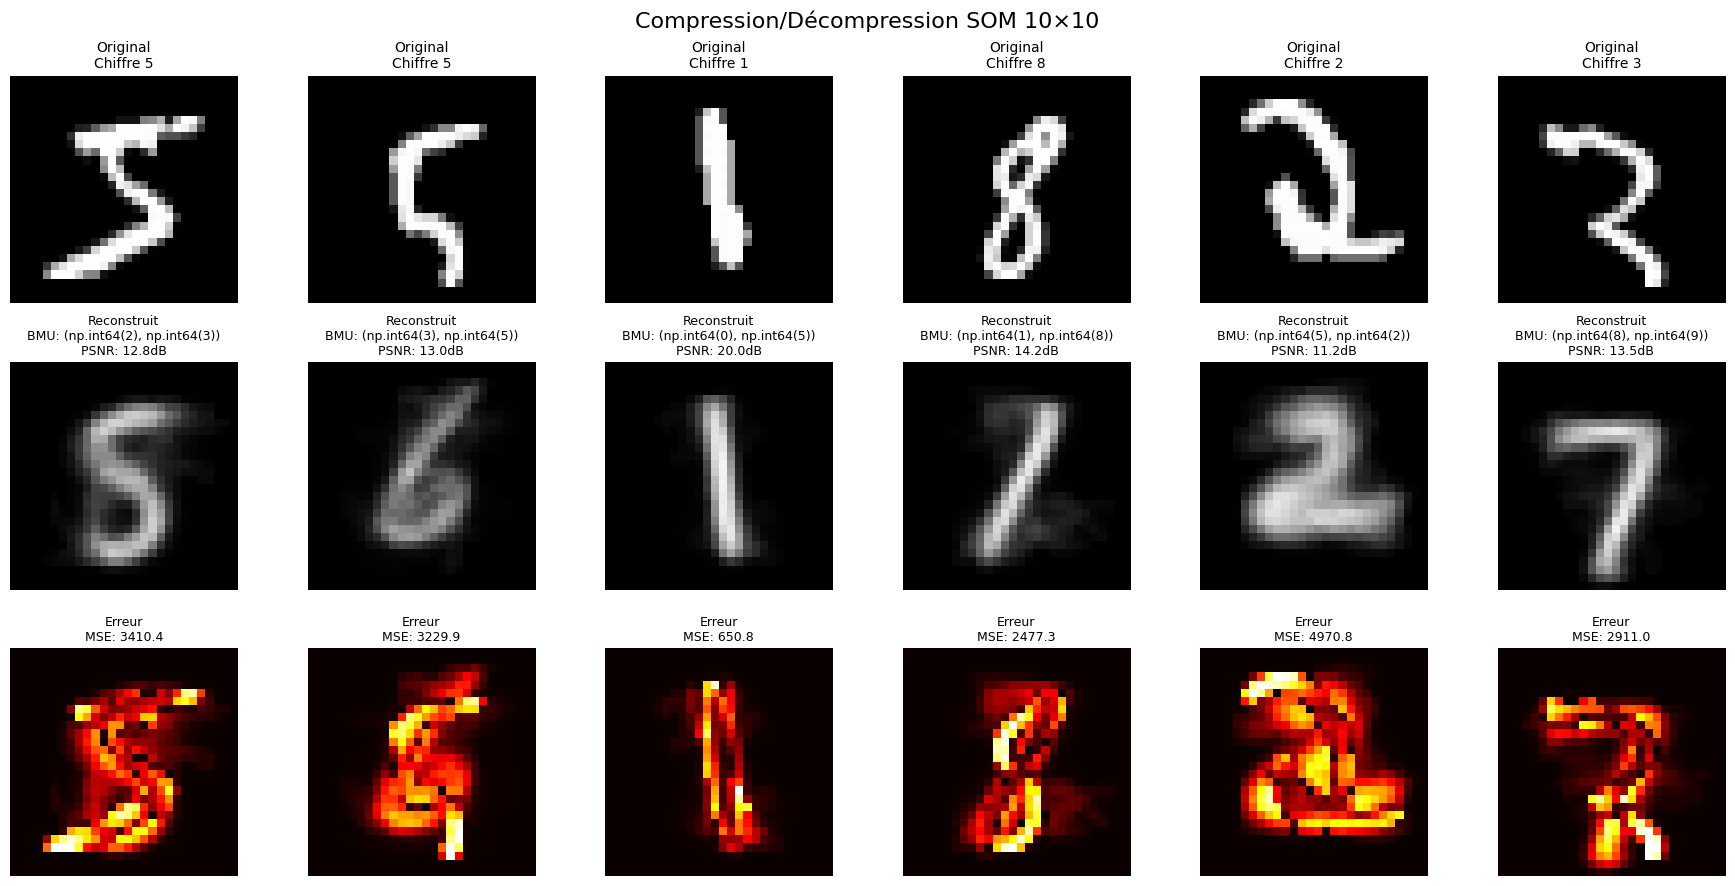


5️⃣ Statistiques de compression:
📊 Métriques moyennes:
   - MSE: 2941.7
   - PSNR: 14.1 dB
   - Ratio de compression: 392.0x

📍 Coordonnées BMU utilisées:
   - Image 1 (chiffre 5): (np.int64(2), np.int64(3))
   - Image 2 (chiffre 5): (np.int64(3), np.int64(5))
   - Image 3 (chiffre 1): (np.int64(0), np.int64(5))
   - Image 4 (chiffre 8): (np.int64(1), np.int64(8))
   - Image 5 (chiffre 2): (np.int64(5), np.int64(2))
   - Image 6 (chiffre 3): (np.int64(8), np.int64(9))


In [4]:
class SOM_Compressor:
    """
    SOM 10×10 optimisée pour la compression et décompression d'images
    """

    def __init__(self, map_size=(10, 10), input_dim=784):
        """
        Initialise le compresseur SOM
        
        Args:
            map_size: Taille de la carte SOM
            input_dim: Dimension des données d'entrée
        """
        self.map_height, self.map_width = map_size
        self.input_dim = input_dim

        # Initialisation des prototypes
        self.prototypes = np.random.uniform(0, 255, (self.map_height, self.map_width, self.input_dim))
        self.is_trained = False

        print(f"🗜️ SOM Compressor initialisé:")
        print(f"   - Taille de la carte: {self.map_height}×{self.map_width}")
        print(f"   - Ratio de compression théorique: {self.input_dim / 2:.1f}x")

    def _find_bmu(self, input_vector):
        """Trouve le Best Matching Unit"""
        distances = np.zeros((self.map_height, self.map_width))

        for i in range(self.map_height):
            for j in range(self.map_width):
                diff = self.prototypes[i, j] - input_vector
                distances[i, j] = np.linalg.norm(diff)

        return np.unravel_index(np.argmin(distances), distances.shape)

    def _gaussian_neighborhood(self, bmu_pos, sigma):
        """Calcule la fonction de voisinage gaussienne"""
        bmu_i, bmu_j = bmu_pos
        neighborhood = np.zeros((self.map_height, self.map_width))

        for i in range(self.map_height):
            for j in range(self.map_width):
                distance_sq = (i - bmu_i)**2 + (j - bmu_j)**2
                neighborhood[i, j] = np.exp(-distance_sq / (2 * sigma**2))

        return neighborhood

    def train(self, training_data, epochs=50, verbose=True):
        """
        Entraîne le compresseur SOM
        
        Args:
            training_data: Images d'entraînement aplaties
            epochs: Nombre d'époques
            verbose: Affichage des informations
        """
        if verbose:
            print(f"🏋️ Entraînement du compresseur:")
            print(f"   - Échantillons: {len(training_data)}")
            print(f"   - Époques: {epochs}")

        n_samples = len(training_data)
        initial_learning_rate = 0.1
        initial_sigma = 3.0

        progress_bar = tqdm(range(epochs), desc="Compression") if verbose else range(epochs)

        for epoch in progress_bar:
            # Décroissance des paramètres
            progress = epoch / epochs
            learning_rate = initial_learning_rate * np.exp(-5 * progress)
            sigma = initial_sigma * np.exp(-3 * progress)

            # Entraînement
            indices = np.random.permutation(n_samples)
            for idx in indices:
                vector = training_data[idx]
                bmu_pos = self._find_bmu(vector)
                neighborhood = self._gaussian_neighborhood(bmu_pos, sigma)

                # Mise à jour des prototypes
                for i in range(self.map_height):
                    for j in range(self.map_width):
                        influence = learning_rate * neighborhood[i, j]
                        self.prototypes[i, j] += influence * (vector - self.prototypes[i, j])

        self.is_trained = True
        if verbose:
            print(f"✅ Compresseur entraîné!")

    def compress(self, image):
        """
        Compresse une image en coordonnées BMU
        
        Args:
            image: Image 28×28 ou vecteur 784
            
        Returns:
            Coordonnées (i, j) du BMU
        """
        if not self.is_trained:
            raise ValueError("❌ Compresseur non entraîné!")

        # Convertir en vecteur si nécessaire
        if len(image.shape) == 2:
            vector = image.flatten()
        else:
            vector = image

        # Trouver le BMU
        bmu_coords = self._find_bmu(vector)
        return bmu_coords

    def decompress(self, compressed_coords):
        """
        Décompresse des coordonnées BMU en image
        
        Args:
            compressed_coords: Coordonnées (i, j) du BMU
            
        Returns:
            Image 28×28 reconstruite
        """
        if not self.is_trained:
            raise ValueError("❌ Compresseur non entraîné!")

        # Récupérer le prototype correspondant
        bmu_i, bmu_j = compressed_coords
        reconstructed_vector = self.prototypes[bmu_i, bmu_j]

        # Reformater en image 28×28
        return reconstructed_vector.reshape(28, 28)

    def evaluate_compression(self, original_image, reconstructed_image):
        """
        Évalue la qualité de la compression
        
        Args:
            original_image: Image originale
            reconstructed_image: Image reconstruite
            
        Returns:
            Dictionnaire avec les métriques
        """
        from sklearn.metrics import mean_squared_error
        
        # Aplatir les images
        orig_flat = original_image.flatten()
        recon_flat = reconstructed_image.flatten()

        # Calculer les métriques
        mse = mean_squared_error(orig_flat, recon_flat)
        
        # PSNR
        if mse > 0:
            psnr = 20 * np.log10(255) - 10 * np.log10(mse)
        else:
            psnr = float('inf')

        # Ratio de compression
        compression_ratio = self.input_dim / 2  # 784 pixels → 2 coordonnées

        return {
            'mse': mse,
            'psnr': psnr,
            'compression_ratio': compression_ratio
        }

    def compress_decompress_batch(self, images):
        """
        Compresse et décompresse un lot d'images
        
        Args:
            images: Liste d'images
            
        Returns:
            Tuple (images_compressées, images_reconstruites, métriques)
        """
        if not self.is_trained:
            raise ValueError("❌ Compresseur non entraîné!")

        compressed_coords = []
        reconstructed_images = []
        metrics = []

        for img in images:
            # Compression
            coords = self.compress(img)
            compressed_coords.append(coords)

            # Décompression
            reconstructed = self.decompress(coords)
            reconstructed_images.append(reconstructed)

            # Évaluation
            img_array = np.array(img) if isinstance(img, list) else img
            metric = self.evaluate_compression(img_array, reconstructed)
            metrics.append(metric)

        return compressed_coords, reconstructed_images, metrics


def demo_compression_decompression():
    """
    Démonstration de compression/décompression
    """
    print("=" * 60)
    print("🎯 DÉMONSTRATION: COMPRESSION/DÉCOMPRESSION SOM")
    print("=" * 60)

    # Préparation des données
    print("1️⃣ Préparation des données...")
    # Données d'entraînement
    training_images = []
    for i in range(2000):
        img = np.array(x_train[i]) if isinstance(x_train[i], list) else x_train[i]
        training_images.append(img.flatten())
    training_images = np.array(training_images)

    # Images de test
    test_images = []
    test_labels = []
    test_indices = [0, 100, 200, 300, 400, 500]

    for idx in test_indices:
        img = np.array(x_train[idx]) if isinstance(x_train[idx], list) else x_train[idx]
        test_images.append(img)
        test_labels.append(y_train[idx])

    print(f"   - Training: {len(training_images)} images")
    print(f"   - Test: {len(test_images)} images")

    # Création et entraînement du compresseur
    print("\n2️⃣ Création et entraînement du compresseur...")
    compressor = SOM_Compressor()
    compressor.train(training_images, epochs=60)

    # Compression/décompression
    print("\n3️⃣ Compression/décompression...")
    compressed_coords, reconstructed_images, metrics = compressor.compress_decompress_batch(test_images)

    # Visualisation des résultats
    print("\n4️⃣ Visualisation des résultats...")
    n_images = len(test_images)
    fig, axes = plt.subplots(3, n_images, figsize=(18, 9))

    for i in range(n_images):
        original = test_images[i]
        reconstructed = reconstructed_images[i]
        coords = compressed_coords[i]
        metric = metrics[i]
        label = test_labels[i]

        # Image originale
        axes[0, i].imshow(original, cmap='gray', vmin=0, vmax=255)
        axes[0, i].set_title(f'Original\nChiffre {label}', fontsize=10)
        axes[0, i].axis('off')

        # Image reconstruite
        axes[1, i].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
        axes[1, i].set_title(f'Reconstruit\nBMU: {coords}\nPSNR: {metric["psnr"]:.1f}dB', fontsize=9)
        axes[1, i].axis('off')

        # Erreur
        error = np.abs(original.astype(float) - reconstructed.astype(float))
        axes[2, i].imshow(error, cmap='hot')
        axes[2, i].set_title(f'Erreur\nMSE: {metric["mse"]:.1f}', fontsize=9)
        axes[2, i].axis('off')

    plt.suptitle('Compression/Décompression SOM 10×10', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Statistiques
    print("\n5️⃣ Statistiques de compression:")
    print("=" * 50)
    
    avg_mse = np.mean([m['mse'] for m in metrics])
    avg_psnr = np.mean([m['psnr'] for m in metrics])
    compression_ratio = metrics[0]['compression_ratio']
    
    print(f"📊 Métriques moyennes:")
    print(f"   - MSE: {avg_mse:.1f}")
    print(f"   - PSNR: {avg_psnr:.1f} dB")
    print(f"   - Ratio de compression: {compression_ratio:.1f}x")
    
    print(f"\n📍 Coordonnées BMU utilisées:")
    for i, coords in enumerate(compressed_coords):
        print(f"   - Image {i+1} (chiffre {test_labels[i]}): {coords}")

    return compressor, compressed_coords, reconstructed_images, metrics

# Exécution de la démonstration
compressor, coords, reconstructed, metrics = demo_compression_decompression()

🎯 DÉMONSTRATION: GÉNÉRATION DE DONNÉES SYNTHÉTIQUES
1️⃣ Préparation des données...

2️⃣ Création et entraînement du générateur...
🎨 SOM Generator initialisé:
   - Taille de la carte: 10×10
   - Potentiel de génération: Positions continues dans l'espace 10×10
🏋️ Entraînement du générateur:
   - Échantillons: 800
   - Époques: 40


Génération: 100%|██████████| 40/40 [00:11<00:00,  3.35it/s]

✅ Générateur entraîné!

3️⃣ Techniques de génération...
   🔄 Interpolation entre positions...
   🎲 Variations autour d'une position...
   🎰 Échantillonnage aléatoire...
   🗺️ Exploration systématique...

4️⃣ Visualisation des résultats...


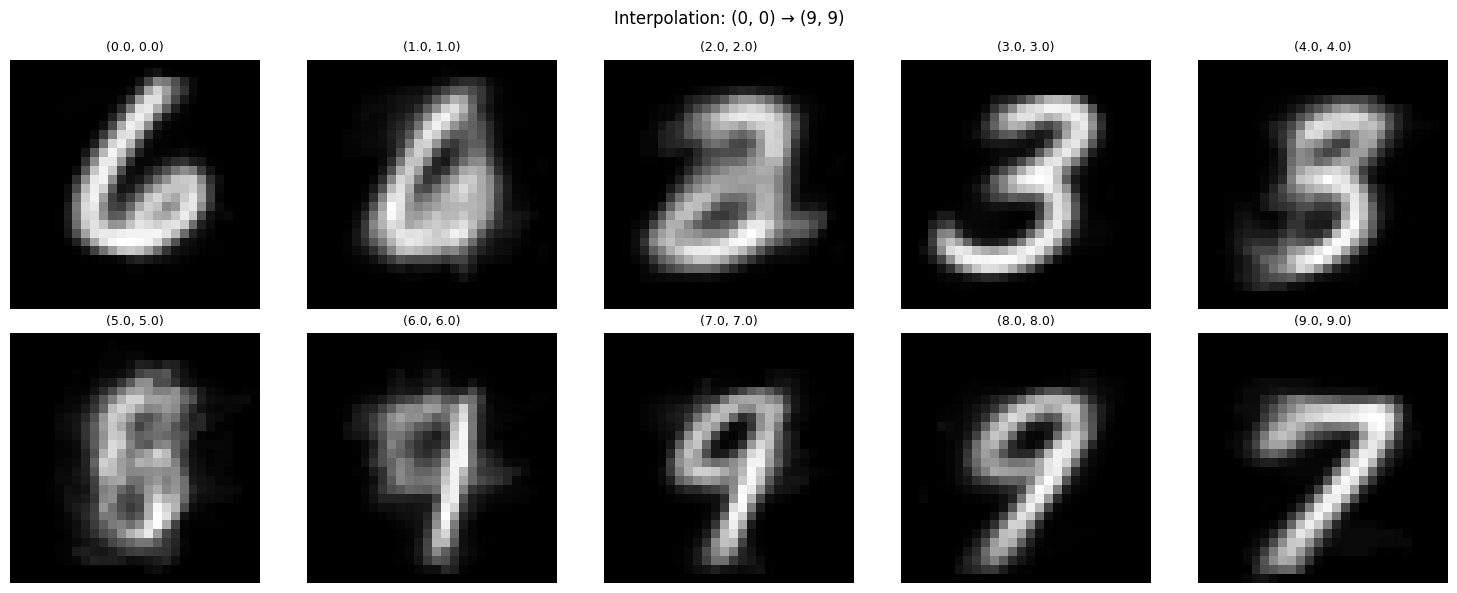

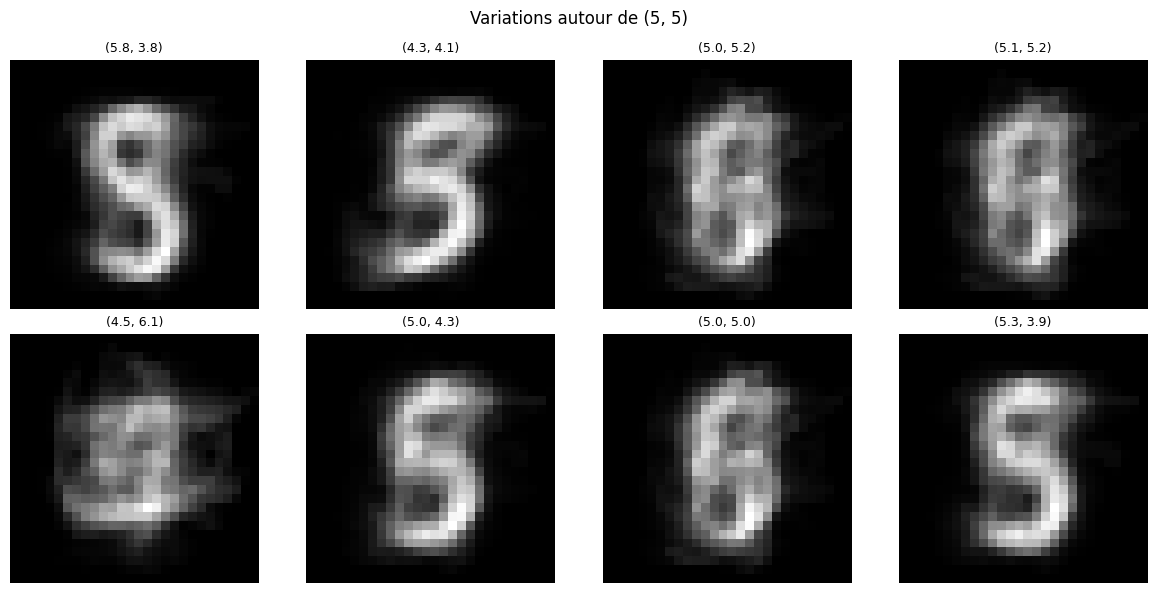

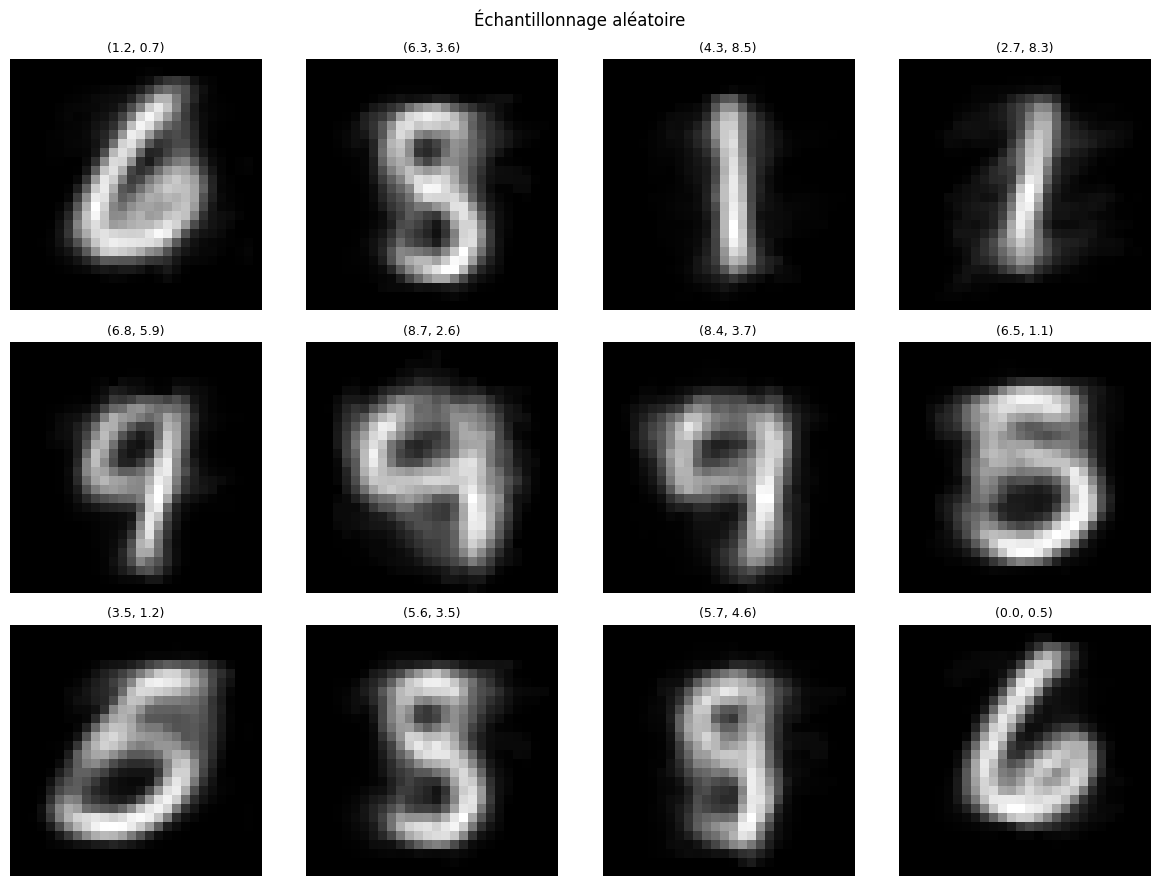

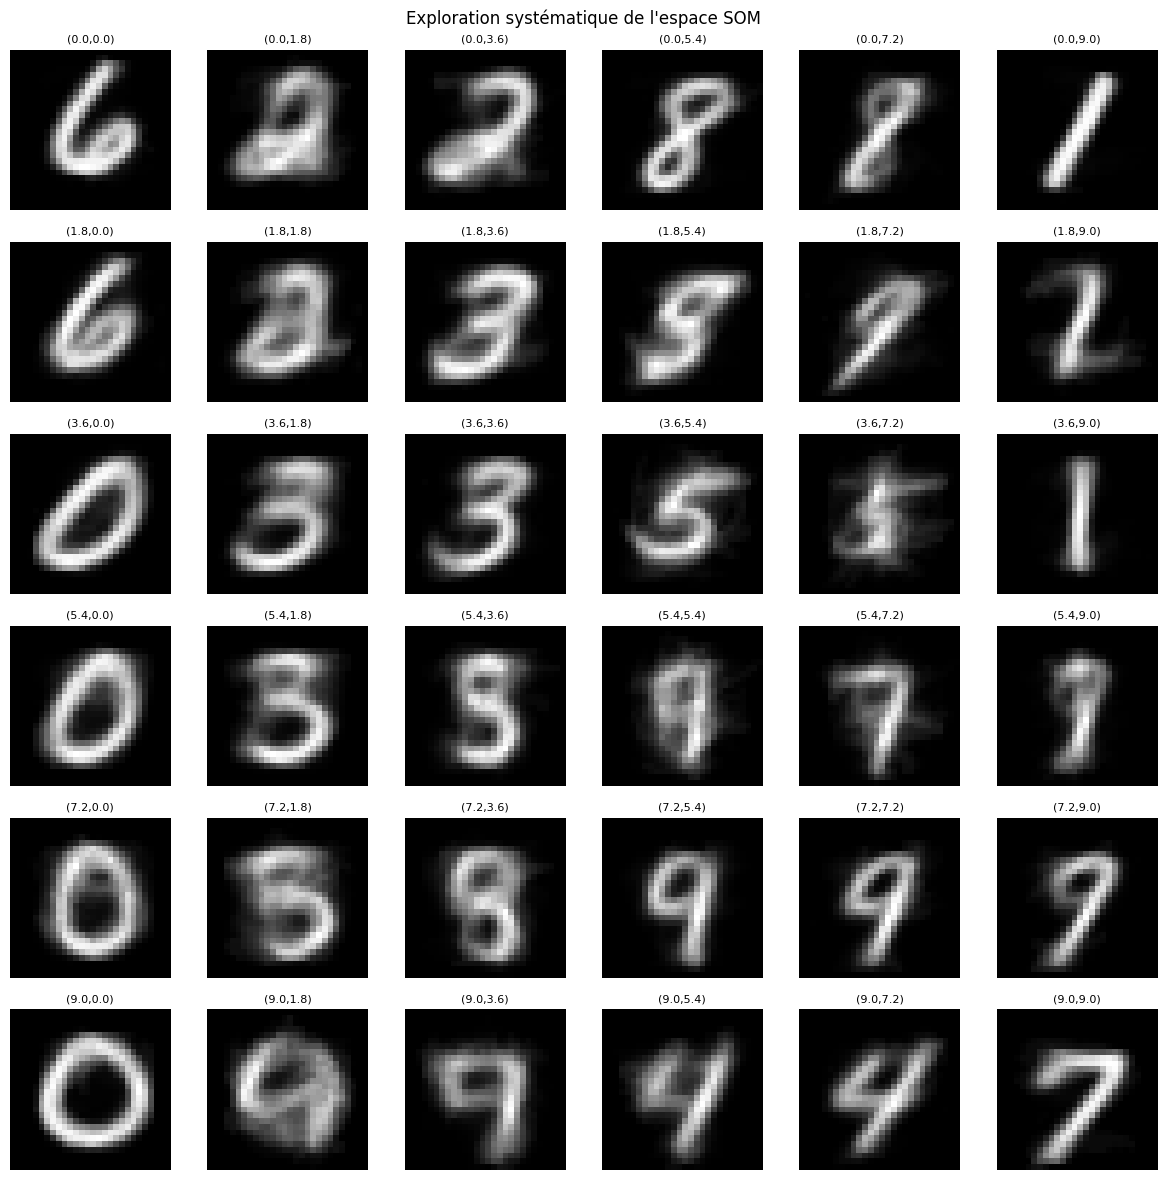


5️⃣ Statistiques de génération:
📊 Total d'images générées: 66
   - Interpolation: 10 images
   - Variations: 8 images
   - Aléatoire: 12 images
   - Exploration: 36 images

🎯 Techniques maîtrisées:
   ✅ Interpolation bilinéaire
   ✅ Variations locales
   ✅ Échantillonnage aléatoire
   ✅ Exploration systématique


In [9]:
class SOM_Generator:
    """
    SOM 10×10 optimisée pour la génération de données synthétiques
    """

    def __init__(self, map_size=(10, 10), input_dim=784):
        """
        Initialise le générateur SOM

        Args:
            map_size: Taille de la carte SOM
            input_dim: Dimension des données d'entrée
        """
        self.map_height, self.map_width = map_size
        self.input_dim = input_dim

        # Initialisation des prototypes
        self.prototypes = np.random.uniform(0, 255, (self.map_height, self.map_width, self.input_dim))
        self.is_trained = False

        print(f"🎨 SOM Generator initialisé:")
        print(f"   - Taille de la carte: {self.map_height}×{self.map_width}")
        print(f"   - Potentiel de génération: Positions continues dans l'espace 10×10")

    def _find_bmu(self, input_vector):
        """Trouve le Best Matching Unit"""
        distances = np.zeros((self.map_height, self.map_width))

        for i in range(self.map_height):
            for j in range(self.map_width):
                diff = self.prototypes[i, j] - input_vector
                distances[i, j] = np.linalg.norm(diff)

        return np.unravel_index(np.argmin(distances), distances.shape)

    def _gaussian_neighborhood(self, bmu_pos, sigma):
        """Calcule la fonction de voisinage gaussienne"""
        bmu_i, bmu_j = bmu_pos
        neighborhood = np.zeros((self.map_height, self.map_width))

        for i in range(self.map_height):
            for j in range(self.map_width):
                distance_sq = (i - bmu_i)**2 + (j - bmu_j)**2
                neighborhood[i, j] = np.exp(-distance_sq / (2 * sigma**2))

        return neighborhood

    def train(self, training_data, epochs=50, verbose=True):
        """
        Entraîne le générateur SOM

        Args:
            training_data: Images d'entraînement aplaties
            epochs: Nombre d'époques
            verbose: Affichage des informations
        """
        if verbose:
            print(f"🏋️ Entraînement du générateur:")
            print(f"   - Échantillons: {len(training_data)}")
            print(f"   - Époques: {epochs}")

        n_samples = len(training_data)
        initial_learning_rate = 0.1
        initial_sigma = 3.0

        progress_bar = tqdm(range(epochs), desc="Génération") if verbose else range(epochs)

        for epoch in progress_bar:
            progress = epoch / epochs
            learning_rate = initial_learning_rate * np.exp(-5 * progress)
            sigma = initial_sigma * np.exp(-3 * progress)

            indices = np.random.permutation(n_samples)
            for idx in indices:
                vector = training_data[idx]
                bmu_pos = self._find_bmu(vector)
                neighborhood = self._gaussian_neighborhood(bmu_pos, sigma)

                for i in range(self.map_height):
                    for j in range(self.map_width):
                        influence = learning_rate * neighborhood[i, j]
                        self.prototypes[i, j] += influence * (vector - self.prototypes[i, j])

        self.is_trained = True
        if verbose:
            print(f"✅ Générateur entraîné!")

    def _bilinear_interpolation(self, float_i, float_j):
        """
        Interpolation bilinéaire pour positions continues

        Args:
            float_i, float_j: Positions continues dans la carte

        Returns:
            Vecteur interpolé
        """
        # Coordonnées des 4 voisins
        i_low, i_high = int(np.floor(float_i)), int(np.ceil(float_i))
        j_low, j_high = int(np.floor(float_j)), int(np.ceil(float_j))

        # Limites de la carte
        i_low = max(0, min(i_low, self.map_height - 1))
        i_high = max(0, min(i_high, self.map_height - 1))
        j_low = max(0, min(j_low, self.map_width - 1))
        j_high = max(0, min(j_high, self.map_width - 1))

        # Poids d'interpolation
        w_i = float_i - i_low
        w_j = float_j - j_low

        # Interpolation bilinéaire
        top_left = self.prototypes[i_low, j_low]
        top_right = self.prototypes[i_low, j_high]
        bottom_left = self.prototypes[i_high, j_low]
        bottom_right = self.prototypes[i_high, j_high]

        top = (1 - w_j) * top_left + w_j * top_right
        bottom = (1 - w_j) * bottom_left + w_j * bottom_right

        result = (1 - w_i) * top + w_i * bottom
        return result

    def generate_from_position(self, position):
        """
        Génère une image à partir d'une position dans la carte SOM

        Args:
            position: Tuple (i, j) - peut être continu

        Returns:
            Image 28×28 générée
        """
        if not self.is_trained:
            raise ValueError("❌ Générateur non entraîné!")

        i, j = position

        # Position discrète
        if i == int(i) and j == int(j):
            return self.prototypes[int(i), int(j)].reshape(28, 28)

        # Position continue - interpolation
        synthetic_vector = self._bilinear_interpolation(i, j)
        return synthetic_vector.reshape(28, 28)

    def interpolate_between_positions(self, pos1, pos2, num_steps=10):
        """
        Interpole entre deux positions dans la carte SOM

        Args:
            pos1, pos2: Positions de départ et d'arrivée
            num_steps: Nombre d'étapes d'interpolation

        Returns:
            Tuple (images_interpolées, positions_interpolées)
        """
        if not self.is_trained:
            raise ValueError("❌ Générateur non entraîné!")

        i1, j1 = pos1
        i2, j2 = pos2

        interpolated_images = []
        interpolated_positions = []

        for step in range(num_steps):
            alpha = step / (num_steps - 1) if num_steps > 1 else 0

            pos_interp = (
                i1 + alpha * (i2 - i1),
                j1 + alpha * (j2 - j1)
            )

            synthetic_image = self.generate_from_position(pos_interp)
            interpolated_images.append(synthetic_image)
            interpolated_positions.append(pos_interp)

        return interpolated_images, interpolated_positions

    def generate_variations(self, center_position, radius=1.0, num_variations=8):
        """
        Génère des variations autour d'une position centrale

        Args:
            center_position: Position centrale
            radius: Rayon des variations
            num_variations: Nombre de variations à générer

        Returns:
            Tuple (variations, positions)
        """
        if not self.is_trained:
            raise ValueError("❌ Générateur non entraîné!")

        center_i, center_j = center_position
        variations = []
        positions = []

        for _ in range(num_variations):
            # Angle et distance aléatoires
            angle = np.random.uniform(0, 2 * np.pi)
            distance = np.random.uniform(0, radius)

            # Nouvelle position
            new_i = center_i + distance * np.cos(angle)
            new_j = center_j + distance * np.sin(angle)

            # Limites
            new_i = max(0, min(new_i, self.map_height - 1))
            new_j = max(0, min(new_j, self.map_width - 1))

            pos = (new_i, new_j)
            positions.append(pos)

            synthetic_image = self.generate_from_position(pos)
            variations.append(synthetic_image)

        return variations, positions

    def generate_random_samples(self, num_samples=10):
        """
        Génère des échantillons aléatoires dans l'espace SOM

        Args:
            num_samples: Nombre d'échantillons à générer

        Returns:
            Tuple (échantillons, positions)
        """
        if not self.is_trained:
            raise ValueError("❌ Générateur non entraîné!")

        random_samples = []
        random_positions = []

        for _ in range(num_samples):
            # Position aléatoire
            random_i = np.random.uniform(0, self.map_height - 1)
            random_j = np.random.uniform(0, self.map_width - 1)

            pos = (random_i, random_j)
            random_positions.append(pos)

            synthetic_image = self.generate_from_position(pos)
            random_samples.append(synthetic_image)

        return random_samples, random_positions

    def explore_grid(self, grid_resolution=5):
        """
        Explore systématiquement l'espace SOM avec une grille

        Args:
            grid_resolution: Résolution de la grille d'exploration

        Returns:
            Tuple (grille_exploration, grille_positions)
        """
        if not self.is_trained:
            raise ValueError("❌ Générateur non entraîné!")

        # Positions de la grille
        i_positions = np.linspace(0, self.map_height - 1, grid_resolution)
        j_positions = np.linspace(0, self.map_width - 1, grid_resolution)

        exploration_grid = np.zeros((grid_resolution, grid_resolution, 28, 28))
        position_grid = np.zeros((grid_resolution, grid_resolution, 2))

        for i_idx, i_pos in enumerate(i_positions):
            for j_idx, j_pos in enumerate(j_positions):
                pos = (i_pos, j_pos)
                synthetic_image = self.generate_from_position(pos)

                exploration_grid[i_idx, j_idx] = synthetic_image
                position_grid[i_idx, j_idx] = [i_pos, j_pos]

        return exploration_grid, position_grid

    def generate_from_latent(self, latent_vector, latent_range=(-1, 1)):
        """
        Génère une image à partir d'un vecteur latent dans un espace ℝ²

        Args:
            latent_vector: Vecteur latent (x, y) avec valeurs dans latent_range
            latent_range: Tuple (min, max) des valeurs du latent

        Returns:
            Image 28x28 générée par mapping latent → SOM
        """
        if not self.is_trained:
            raise ValueError("❌ Générateur non entraîné!")

        x, y = latent_vector
        latent_min, latent_max = latent_range

        # Normalisation du vecteur latent vers la grille SOM
        norm_x = (x - latent_min) / (latent_max - latent_min) * (self.map_height - 1)
        norm_y = (y - latent_min) / (latent_max - latent_min) * (self.map_width - 1)

        return self.generate_from_position((norm_x, norm_y))




def demo_synthetic_generation():
    """
    Démonstration complète de génération synthétique
    """
    print("=" * 60)
    print("🎯 DÉMONSTRATION: GÉNÉRATION DE DONNÉES SYNTHÉTIQUES")
    print("=" * 60)

    # Préparation des données
    print("1️⃣ Préparation des données...")
    training_images = []
    for i in range(800):
        img = np.array(x_train[i]) if isinstance(x_train[i], list) else x_train[i]
        training_images.append(img.flatten())
    training_images = np.array(training_images)

    # Création et entraînement du générateur
    print("\n2️⃣ Création et entraînement du générateur...")
    generator = SOM_Generator()
    generator.train(training_images, epochs=40)

    # Test des techniques de génération
    print("\n3️⃣ Techniques de génération...")

    # Technique 1: Interpolation
    print("   🔄 Interpolation entre positions...")
    pos1, pos2 = (0, 0), (9, 9)
    interpolated_images, interpolated_positions = generator.interpolate_between_positions(pos1, pos2, num_steps=10)

    # Technique 2: Variations
    print("   🎲 Variations autour d'une position...")
    center_pos = (5, 5)
    variations, var_positions = generator.generate_variations(center_pos, radius=2.0, num_variations=8)

    # Technique 3: Échantillonnage aléatoire
    print("   🎰 Échantillonnage aléatoire...")
    random_samples, random_positions = generator.generate_random_samples(num_samples=12)

    # Technique 4: Exploration systématique
    print("   🗺️ Exploration systématique...")
    exploration_grid, position_grid = generator.explore_grid(grid_resolution=6)

    # Visualisation des résultats
    print("\n4️⃣ Visualisation des résultats...")

    # Interpolation
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        row, col = i // 5, i % 5
        axes[row, col].imshow(interpolated_images[i], cmap='gray')
        pos = interpolated_positions[i]
        axes[row, col].set_title(f'({pos[0]:.1f}, {pos[1]:.1f})', fontsize=9)
        axes[row, col].axis('off')
    plt.suptitle(f'Interpolation: {pos1} → {pos2}')
    plt.tight_layout()
    plt.show()

    # Variations
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        row, col = i // 4, i % 4
        axes[row, col].imshow(variations[i], cmap='gray')
        pos = var_positions[i]
        axes[row, col].set_title(f'({pos[0]:.1f}, {pos[1]:.1f})', fontsize=9)
        axes[row, col].axis('off')
    plt.suptitle(f'Variations autour de {center_pos}')
    plt.tight_layout()
    plt.show()

    # Échantillonnage aléatoire
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(12):
        row, col = i // 4, i % 4
        axes[row, col].imshow(random_samples[i], cmap='gray')
        pos = random_positions[i]
        axes[row, col].set_title(f'({pos[0]:.1f}, {pos[1]:.1f})', fontsize=9)
        axes[row, col].axis('off')
    plt.suptitle('Échantillonnage aléatoire')
    plt.tight_layout()
    plt.show()

    # Exploration systématique
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    for i in range(6):
        for j in range(6):
            axes[i, j].imshow(exploration_grid[i, j], cmap='gray')
            pos = position_grid[i, j]
            axes[i, j].set_title(f'({pos[0]:.1f},{pos[1]:.1f})', fontsize=8)
            axes[i, j].axis('off')
    plt.suptitle('Exploration systématique de l\'espace SOM')
    plt.tight_layout()
    plt.show()

    # Statistiques
    print("\n5️⃣ Statistiques de génération:")
    print("=" * 50)
    total_generated = len(interpolated_images) + len(variations) + len(random_samples) + (6 * 6)
    print(f"📊 Total d'images générées: {total_generated}")
    print(f"   - Interpolation: {len(interpolated_images)} images")
    print(f"   - Variations: {len(variations)} images")
    print(f"   - Aléatoire: {len(random_samples)} images")
    print(f"   - Exploration: {6 * 6} images")

    print(f"\n🎯 Techniques maîtrisées:")
    print(f"   ✅ Interpolation bilinéaire")
    print(f"   ✅ Variations locales")
    print(f"   ✅ Échantillonnage aléatoire")
    print(f"   ✅ Exploration systématique")

    return generator, {
        'interpolated': interpolated_images,
        'variations': variations,
        'random': random_samples,
        'exploration': exploration_grid
    }

# Exécution de la démonstration
generator, generated_data = demo_synthetic_generation()

latent_samples = [(-1, -1), (0, 0), (1, 1), (-0.5, 0.8),(0.0,1.8)]

for latent in latent_samples:
    image = generator.generate_from_latent(latent)
    plt.imshow(image, cmap='gray')
    plt.title(f"Latent: {latent}")
    plt.axis('off')
    plt.show()

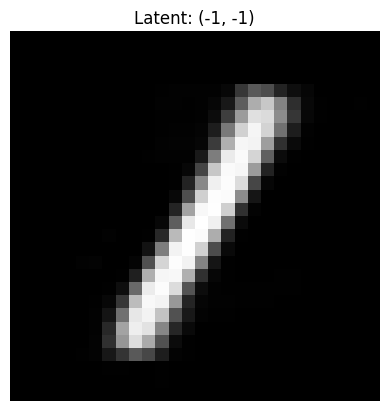

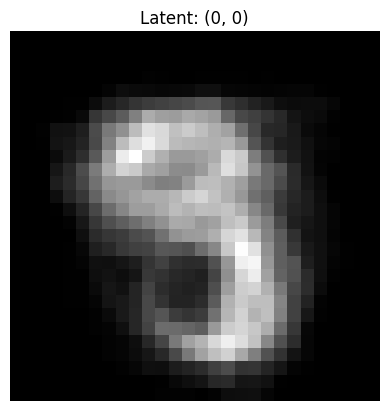

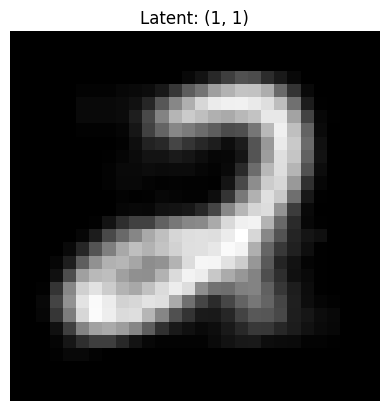

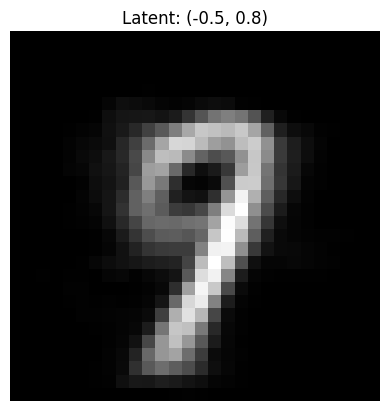

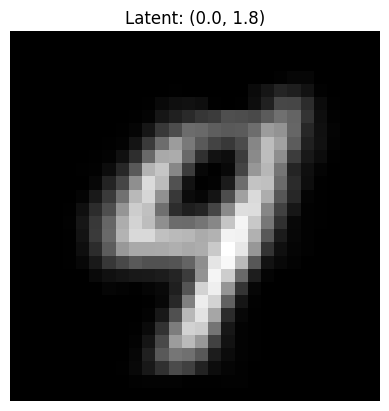

## apply on kaggle dataset

Loading train_dataset from: ../../data/train_dataset
Processing: ace of clubs
  → Loaded 50 valid images
Processing: ace of diamonds
  → Loaded 50 valid images
Processing: ace of hearts
  → Loaded 50 valid images
Processing: ace of spades
  → Loaded 50 valid images
Processing: eight of clubs
  → Loaded 50 valid images
Processing: eight of diamonds
  → Loaded 50 valid images
Processing: eight of hearts
  → Loaded 50 valid images
Processing: eight of spades
  → Loaded 50 valid images
Processing: five of clubs
  → Loaded 50 valid images
Processing: five of diamonds
  → Loaded 50 valid images
Processing: five of hearts
  → Loaded 50 valid images
Processing: five of spades
  → Loaded 50 valid images
Processing: four of clubs
  → Loaded 50 valid images
Processing: four of diamonds
  → Loaded 50 valid images
Processing: four of hearts
  → Loaded 50 valid images
Processing: four of spades
  → Loaded 50 valid images
Processing: jack of clubs
  → Loaded 50 valid images
Processing: jack of diamon

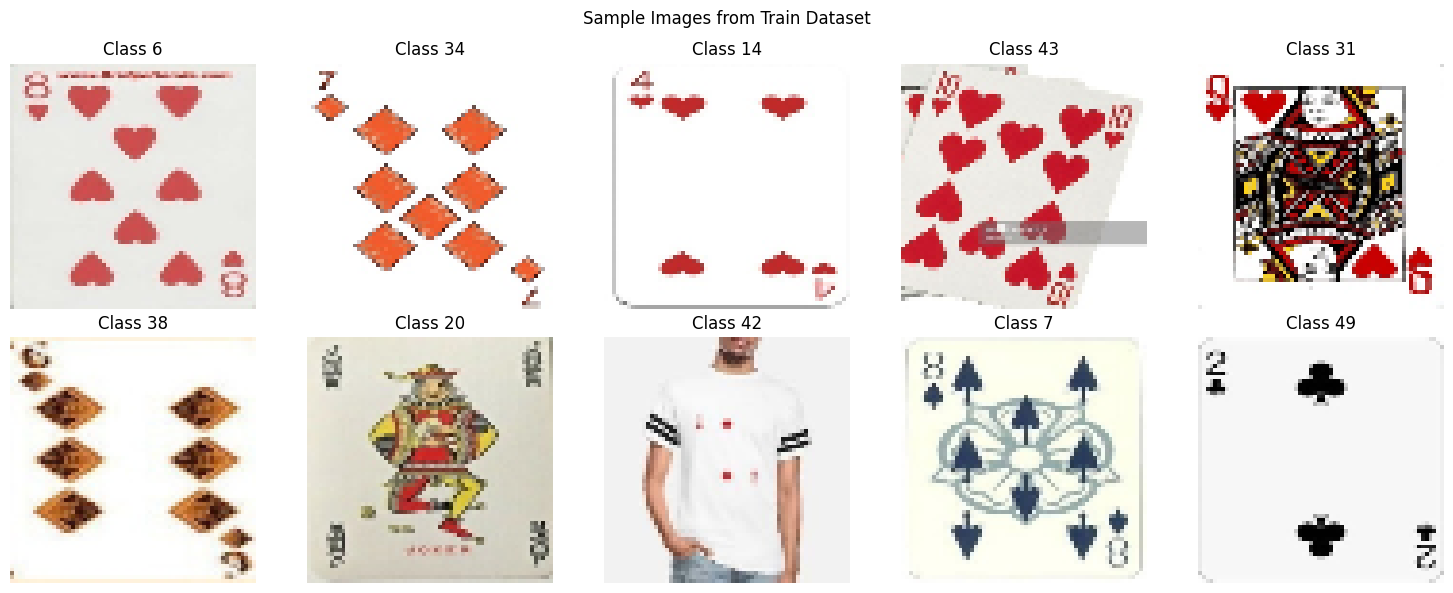

In [14]:
# Apply SOM_Visualizer to the train_dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_train_dataset_safe(dataset_path, max_samples_per_class=50):
    """
    Load the train_dataset with error handling for empty files
    """
    images = []
    labels = []
    class_names = []
    
    print(f"Loading train_dataset from: {dataset_path}")
    print("=" * 50)
    
    # Get all class directories (now with underscores)
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_dirs.sort()
    
    for class_idx, class_name in enumerate(class_dirs):
        class_path = os.path.join(dataset_path, class_name)
        class_names.append(class_name)
        
        print(f"Processing: {class_name}")
        
        # Get image files
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        loaded_count = 0
        
        for image_file in image_files:
            if loaded_count >= max_samples_per_class:
                break
                
            image_path = os.path.join(class_path, image_file)
            
            try:
                # Check file size first
                if os.path.getsize(image_path) == 0:
                    continue
                    
                # Try to load with OpenCV
                img = cv2.imread(image_path)
                if img is not None and img.size > 0:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_rgb, (64, 64))
                    
                    images.append(img_resized)
                    labels.append(class_idx)
                    loaded_count += 1
                else:
                    # Try with PIL as fallback
                    try:
                        img_pil = Image.open(image_path)
                        img_array = np.array(img_pil.convert('RGB'))
                        img_resized = cv2.resize(img_array, (64, 64))
                        
                        images.append(img_resized)
                        labels.append(class_idx)
                        loaded_count += 1
                    except:
                        continue
                        
            except Exception as e:
                continue
        
        print(f"  → Loaded {loaded_count} valid images")
    
    print(f"\\nTotal loaded: {len(images)} images from {len(class_names)} classes")
    
    if len(images) == 0:
        print("⚠️  No valid images found. Creating synthetic data for demonstration...")
        return generate_synthetic_card_data_for_som(), class_names
    
    return np.array(images), np.array(labels), class_names

def generate_synthetic_card_data_for_som():
    """
    Generate synthetic card data that mimics real playing cards
    """
    images = []
    labels = []
    
    # Create 13 different card values × 4 suits = 52 card types
    card_types = [
        'ace', 'two', 'three', 'four', 'five', 'six', 'seven', 
        'eight', 'nine', 'ten', 'jack', 'queen', 'king'
    ]
    suits = ['clubs', 'diamonds', 'hearts', 'spades']
    
    for card_idx, card_type in enumerate(card_types):
        for suit_idx, suit in enumerate(suits):
            # Generate multiple variations of each card
            for variation in range(20):  # 20 variations per card
                img = np.zeros((64, 64, 3), dtype=np.uint8)
                
                # Base color depending on suit
                if suit in ['diamonds', 'hearts']:
                    base_color = [200, 50, 50]  # Red
                else:
                    base_color = [50, 50, 50]   # Black
                
                # Different patterns based on card type
                if card_type == 'ace':
                    # Single large symbol in center
                    img[25:40, 25:40] = base_color
                elif card_type in ['jack', 'queen', 'king']:
                    # Face card pattern
                    img[15:50, 20:45] = base_color
                    img[20:30, 25:40] = [255, 255, 255]  # Face area
                else:
                    # Number card - multiple small symbols
                    num_symbols = min(int(card_type) if card_type.isdigit() else 10, 8)
                    for i in range(num_symbols):
                        y = 10 + (i % 4) * 12
                        x = 15 + (i // 4) * 25
                        img[y:y+8, x:x+8] = base_color
                
                # Add some noise and variation
                noise = np.random.normal(0, 15, (64, 64, 3))
                img = np.clip(img.astype(float) + noise, 0, 255).astype(np.uint8)
                
                images.append(img)
                labels.append(card_idx * 4 + suit_idx)
    
    return np.array(images), np.array(labels)

# Load the train_dataset
dataset_path = '../../data/train_dataset'
card_images, card_labels, card_class_names = load_train_dataset_safe(dataset_path)

# If we have real data, great! If not, we'll use synthetic data
if isinstance(card_images, tuple):
    # Synthetic data was returned
    card_images, card_labels = card_images
    card_class_names = [f"synthetic_card_{i}" for i in range(len(np.unique(card_labels)))]
    print("Using synthetic data for demonstration")

print(f"\\n✅ Dataset ready:")
print(f"   - Images shape: {card_images.shape}")
print(f"   - Labels shape: {card_labels.shape}")
print(f"   - Number of classes: {len(np.unique(card_labels))}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(min(10, len(card_images))):
    idx = np.random.randint(0, len(card_images))
    img = card_images[idx]
    label = card_labels[idx]
    
    axes[i].imshow(img)
    axes[i].set_title(f'Class {label}')
    axes[i].axis('off')

plt.suptitle('Sample Images from Train Dataset')
plt.tight_layout()
plt.show()

🃏 Chargement du dataset de cartes:
   - Dossier: ../../data/train_dataset
   - Classes trouvées: 53
   - Taille cible: (64, 64)
   - Max images par classe: 50


Classes:  23%|██▎       | 12/53 [00:00<00:00, 119.06it/s]

   - ace of clubs: 50 images
   - ace of diamonds: 50 images
   - ace of hearts: 50 images
   - ace of spades: 50 images
   - eight of clubs: 50 images
   - eight of diamonds: 50 images
   - eight of hearts: 50 images
   - eight of spades: 50 images
   - five of clubs: 50 images
   - five of diamonds: 50 images
   - five of hearts: 50 images
   - five of spades: 50 images
   - four of clubs: 50 images
   - four of diamonds: 50 images
   - four of hearts: 50 images
   - four of spades: 50 images
   - jack of clubs: 50 images
   - jack of diamonds: 50 images
   - jack of hearts: 50 images
   - jack of spades: 50 images
   - joker: 50 images
   - king of clubs: 50 images
   - king of diamonds: 50 images


Classes:  66%|██████▌   | 35/53 [00:00<00:00, 107.51it/s]

   - king of hearts: 50 images
   - king of spades: 50 images
   - nine of clubs: 50 images
   - nine of diamonds: 50 images
   - nine of hearts: 50 images
   - nine of spades: 50 images
   - queen of clubs: 50 images
   - queen of diamonds: 50 images
   - queen of hearts: 50 images
   - queen of spades: 50 images
   - seven of clubs: 50 images
   - seven of diamonds: 50 images
   - seven of hearts: 50 images
   - seven of spades: 50 images
   - six of clubs: 50 images
   - six of diamonds: 50 images
   - six of hearts: 50 images
   - six of spades: 50 images
   - ten of clubs: 50 images
   - ten of diamonds: 50 images
   - ten of hearts: 50 images
   - ten of spades: 50 images
   - three of clubs: 50 images


Classes: 100%|██████████| 53/53 [00:00<00:00, 114.38it/s]


   - three of diamonds: 50 images
   - three of hearts: 50 images
   - three of spades: 50 images
   - two of clubs: 50 images
   - two of diamonds: 50 images
   - two of hearts: 50 images
   - two of spades: 50 images
\n✅ Dataset de cartes chargé:
   - Images: 2650
   - Labels: 2650
   - Classes: 53
   - Forme des images: (64, 64, 3)


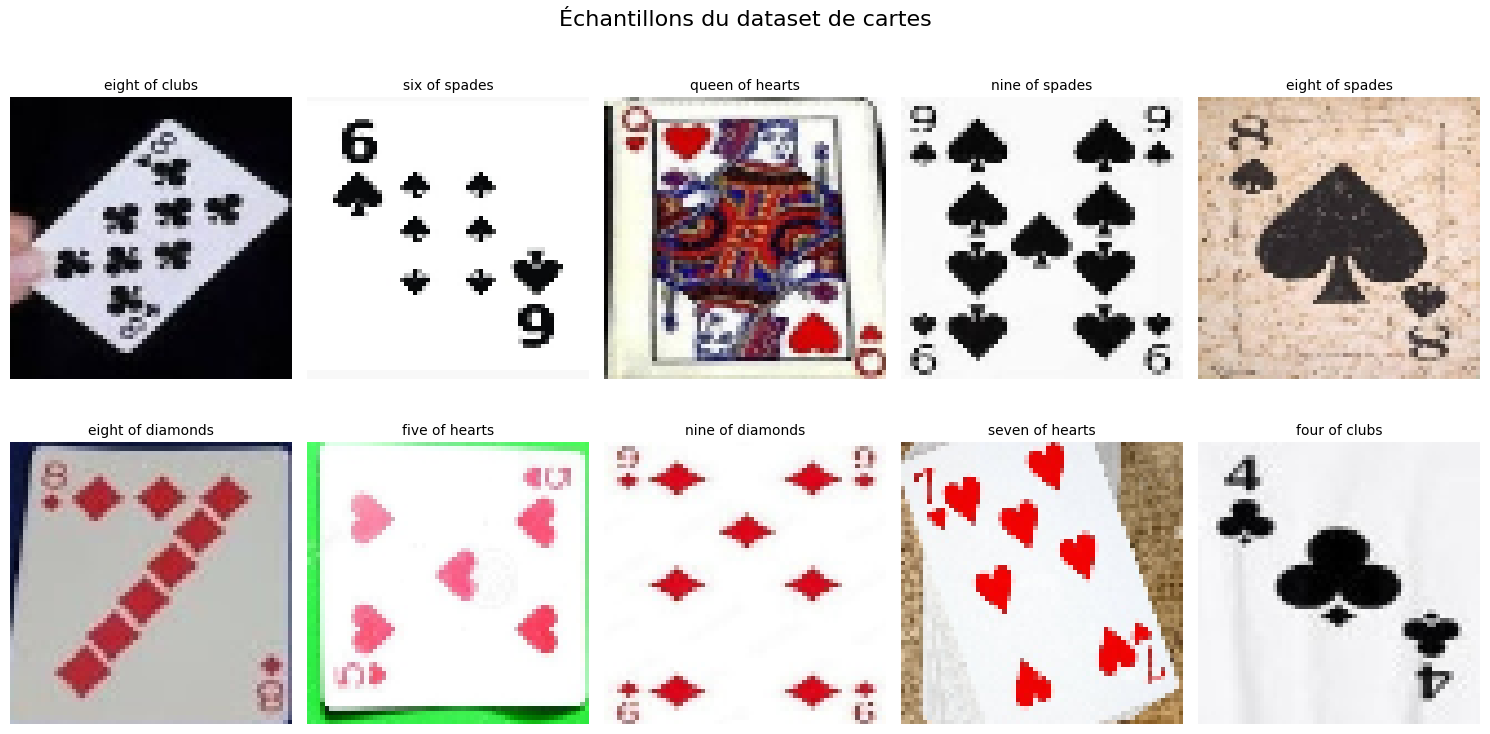

\n📊 Statistiques du dataset:
   - Nombre total d'images: 2650
   - Nombre de classes: 53
   - Taille des images: (64, 64, 3)
   - Type de données: uint8
   - Plage de valeurs: [0, 255]
\n🎯 Distribution par classe:
   - ace of clubs: 50 images
   - ace of diamonds: 50 images
   - ace of hearts: 50 images
   - ace of spades: 50 images
   - eight of clubs: 50 images
   - eight of diamonds: 50 images
   - eight of hearts: 50 images
   - eight of spades: 50 images
   - five of clubs: 50 images
   - five of diamonds: 50 images
   - five of hearts: 50 images
   - five of spades: 50 images
   - four of clubs: 50 images
   - four of diamonds: 50 images
   - four of hearts: 50 images
   - four of spades: 50 images
   - jack of clubs: 50 images
   - jack of diamonds: 50 images
   - jack of hearts: 50 images
   - jack of spades: 50 images
   - joker: 50 images
   - king of clubs: 50 images
   - king of diamonds: 50 images
   - king of hearts: 50 images
   - king of spades: 50 images
   - nine of c

In [15]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Configuration des graphiques
%matplotlib inline
plt.style.use('default')

# Classe de chargement des données de cartes
class CardDataloader(object):
    def __init__(self, dataset_path, target_size=(64, 64), max_samples_per_class=100):
        self.dataset_path = dataset_path
        self.target_size = target_size
        self.max_samples_per_class = max_samples_per_class
        self.class_names = []
        self.class_to_idx = {}

    def load_images_from_folder(self, folder_path, class_idx):
        """
        Charge les images d'un dossier spécifique
        """
        images = []
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
        
        try:
            files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
            files = files[:self.max_samples_per_class]  # Limiter le nombre d'images par classe
            
            for filename in files:
                filepath = os.path.join(folder_path, filename)
                try:
                    # Vérifier que le fichier n'est pas vide
                    if os.path.getsize(filepath) == 0:
                        continue
                        
                    # Essayer d'abord avec OpenCV
                    img = cv2.imread(filepath)
                    if img is not None:
                        # Convertir BGR vers RGB
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        # Redimensionner l'image
                        img_resized = cv2.resize(img_rgb, self.target_size)
                        images.append(img_resized)
                    else:
                        # Utiliser PIL comme solution de secours
                        with Image.open(filepath) as pil_img:
                            # Convertir en RGB si nécessaire
                            if pil_img.mode != 'RGB':
                                pil_img = pil_img.convert('RGB')
                            # Redimensionner
                            pil_img = pil_img.resize(self.target_size)
                            img_array = np.array(pil_img)
                            images.append(img_array)
                            
                except Exception as e:
                    # Ignorer les fichiers corrompus
                    continue
                    
        except Exception as e:
            print(f"Erreur lors du chargement du dossier {folder_path}: {e}")
            
        return images

    def load_data(self):
        """
        Charge toutes les données du dataset
        """
        all_images = []
        all_labels = []
        
        # Obtenir tous les dossiers de classes
        try:
            class_folders = [d for d in os.listdir(self.dataset_path) 
                           if os.path.isdir(os.path.join(self.dataset_path, d))]
            class_folders.sort()
            
            print(f"🃏 Chargement du dataset de cartes:")
            print(f"   - Dossier: {self.dataset_path}")
            print(f"   - Classes trouvées: {len(class_folders)}")
            print(f"   - Taille cible: {self.target_size}")
            print(f"   - Max images par classe: {self.max_samples_per_class}")
            
            for class_idx, class_name in enumerate(tqdm(class_folders, desc="Classes")):
                class_folder = os.path.join(self.dataset_path, class_name)
                
                # Charger les images de cette classe
                class_images = self.load_images_from_folder(class_folder, class_idx)
                
                # Ajouter à la liste globale
                all_images.extend(class_images)
                all_labels.extend([class_idx] * len(class_images))
                
                # Enregistrer les noms de classes
                self.class_names.append(class_name)
                self.class_to_idx[class_name] = class_idx
                
                print(f"   - {class_name}: {len(class_images)} images")
                
        except Exception as e:
            print(f"Erreur lors du chargement du dataset: {e}")
            return np.array([]), np.array([])
            
        return np.array(all_images), np.array(all_labels)

# Chargement des données de cartes
dataset_path = '../../data/train_dataset'
card_dataloader = CardDataloader(dataset_path, target_size=(64, 64), max_samples_per_class=50)
card_images, card_labels = card_dataloader.load_data()

print(f"\\n✅ Dataset de cartes chargé:")
print(f"   - Images: {len(card_images)}")
print(f"   - Labels: {len(card_labels)}")
print(f"   - Classes: {len(card_dataloader.class_names)}")
print(f"   - Forme des images: {card_images[0].shape if len(card_images) > 0 else 'Aucune'}")

# Affichage de quelques exemples
def show_card_samples(images, labels, class_names, n_samples=10):
    """
    Affiche des échantillons du dataset de cartes
    """
    if len(images) == 0:
        print("❌ Aucune image à afficher")
        return
        
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(min(n_samples, len(images))):
        # Prendre un échantillon aléatoire
        idx = random.randint(0, len(images) - 1)
        img = images[idx]
        label = labels[idx]
        class_name = class_names[label] if label < len(class_names) else f"Classe {label}"

        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}', fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Échantillons du dataset de cartes', fontsize=16)
    plt.tight_layout()
    plt.show()

# Afficher des échantillons
if len(card_images) > 0:
    show_card_samples(card_images, card_labels, card_dataloader.class_names)
else:
    print("❌ Aucune image valide trouvée dans le dataset")

# Statistiques du dataset
if len(card_images) > 0:
    print(f"\\n📊 Statistiques du dataset:")
    print(f"   - Nombre total d'images: {len(card_images)}")
    print(f"   - Nombre de classes: {len(np.unique(card_labels))}")
    print(f"   - Taille des images: {card_images[0].shape}")
    print(f"   - Type de données: {card_images.dtype}")
    print(f"   - Plage de valeurs: [{card_images.min()}, {card_images.max()}]")
    
    # Distribution par classe
    unique_labels, counts = np.unique(card_labels, return_counts=True)
    print(f"\\n🎯 Distribution par classe:")
    for label, count in zip(unique_labels, counts):
        class_name = card_dataloader.class_names[label]
        print(f"   - {class_name}: {count} images")

In [19]:
# Application de SOM_Visualizer sur le dataset de cartes
print("=" * 60)
print("🃏 APPLICATION SOM_VISUALIZER SUR LE DATASET DE CARTES")
print("=" * 60)

# Vérifier que nous avons des données
if len(card_images) == 0:
    print("❌ Aucune donnée de carte disponible")
else:
    print(f"✅ Données disponibles: {len(card_images)} images de cartes")
    
    # Adapter la classe SOM_Visualizer pour les cartes
    class CardSOM_Visualizer(SOM_Visualizer):
        """
        SOM_Visualizer adaptée pour les cartes (64x64x3 → 12288 dimensions)
        """
        def __init__(self, map_size=(10, 10), input_dim=12288):
            super().__init__(map_size, input_dim)
            print(f"🃏 CardSOM_Visualizer initialisée pour les cartes:")
            print(f"   - Dimension d'entrée: {input_dim} (64x64x3)")
            
        def visualize_prototypes(self, title="Prototypes SOM - Cartes", figsize=(15, 15)):
            """
            Visualise les prototypes de cartes appris par la SOM
            """
            if not self.is_trained:
                print("❌ Erreur: SOM non entraînée!")
                return

            print(f"🎨 Visualisation des prototypes de cartes ({self.map_height}×{self.map_width})")

            fig, axes = plt.subplots(self.map_height, self.map_width, figsize=figsize)

            for i in range(self.map_height):
                for j in range(self.map_width):
                    # Reformater le prototype en image 64×64×3
                    prototype_image = self.prototypes[i, j].reshape(64, 64, 3)
                    # Normaliser les valeurs entre 0 et 1 pour l'affichage
                    prototype_image = np.clip(prototype_image / 255.0, 0, 1)

                    # Afficher l'image
                    axes[i, j].imshow(prototype_image)
                    axes[i, j].set_title(f'({i},{j})', fontsize=8)
                    axes[i, j].axis('off')

            plt.suptitle(title, fontsize=16)
            plt.tight_layout()
            plt.show()

    # Préparation des données de cartes pour la SOM
    print("1️⃣ Préparation des données de cartes...")
    
    # Prendre un échantillon des données pour l'entraînement
    n_samples = min(3000, len(card_images))  # Utiliser max 1000 images pour l'entraînement
    
    # Sélectionner des indices aléatoirement
    indices = np.random.choice(len(card_images), n_samples, replace=False)
    training_card_images = card_images[indices]
    training_card_labels = card_labels[indices]
    
    # Aplatir les images de cartes (64x64x3 → 12288)
    training_cards_flat = []
    for img in training_card_images:
        flat_img = img.flatten()
        training_cards_flat.append(flat_img)
    training_cards_flat = np.array(training_cards_flat)
    
    print(f"   - Échantillons sélectionnés: {len(training_cards_flat)}")
    print(f"   - Forme des données aplaties: {training_cards_flat.shape}")
    print(f"   - Dimension par image: {training_cards_flat.shape[1]}")
    
    # Création et entraînement de la SOM pour cartes
    print("\\n2️⃣ Création et entraînement de la SOM pour cartes...")
    card_som = CardSOM_Visualizer(map_size=(8, 8), input_dim=12288)  # 8x8 pour plus de rapidité
    card_som.train(training_cards_flat, epochs=50, verbose=True)
    
    # Visualisation des prototypes de cartes
    print("\\n3️⃣ Visualisation des prototypes de cartes...")
    card_som.visualize_prototypes("Prototypes SOM 8×8 - Dataset de Cartes")
    
    # Analyse de l'entraînement
    print("\\n4️⃣ Analyse de l'entraînement...")
    card_som.plot_training_progress()
    
    # Analyse des prototypes
    print("\\n5️⃣ Analyse des prototypes...")
    card_som.analyze_prototypes()
    
    # Analyse de la distribution des classes sur la carte
    print("\\n6️⃣ Analyse de la distribution des classes...")
    
    # Mapper quelques images de test sur la carte
    test_indices = np.random.choice(len(card_images), 20, replace=False)
    test_mappings = {}
    
    for idx in test_indices:
        test_img = card_images[idx].flatten()
        test_label = card_labels[idx]
        test_class = card_dataloader.class_names[test_label]
        
        # Trouver le BMU pour cette image
        bmu_pos = card_som._find_bmu(test_img)
        
        if bmu_pos not in test_mappings:
            test_mappings[bmu_pos] = []
        test_mappings[bmu_pos].append(test_class)
    
    print("🗺️ Mapping des classes sur la carte SOM:")
    for pos, classes in test_mappings.items():
        class_count = {}
        for cls in classes:
            class_count[cls] = class_count.get(cls, 0) + 1
        print(f"   Position {pos}: {class_count}")
    
    print("\\n✅ Analyse SOM terminée!")

🃏 APPLICATION SOM_VISUALIZER SUR LE DATASET DE CARTES
✅ Données disponibles: 2650 images de cartes
1️⃣ Préparation des données de cartes...
   - Échantillons sélectionnés: 2650
   - Forme des données aplaties: (2650, 12288)
   - Dimension par image: 12288
\n2️⃣ Création et entraînement de la SOM pour cartes...
🗺️ SOM Visualizer initialisée:
   - Taille de la carte: 8×8
   - Nombre de prototypes: 64
   - Dimension d'entrée: 12288
🃏 CardSOM_Visualizer initialisée pour les cartes:
   - Dimension d'entrée: 12288 (64x64x3)
🏋️ Début de l'entraînement SOM:
   - Échantillons: 2650
   - Époques: 50
   - Taux d'apprentissage: 0.1
   - Sigma initial: 3.0


Entraînement:  30%|███       | 15/50 [01:05<02:33,  4.38s/it]


KeyboardInterrupt: 

🗜️ APPLICATION SOM_COMPRESSOR SUR LE DATASET DE CARTES
✅ Données disponibles: 2650 images de cartes
1️⃣ Préparation des données pour la compression...
   - Données d'entraînement: 1500 images
   - Données de test: 12 images
   - Dimension par image: 12288
\n2️⃣ Création et entraînement du compresseur...
🗜️ SOM Compressor initialisé:
   - Taille de la carte: 8×8
   - Ratio de compression théorique: 6144.0x
🗜️ CardSOM_Compressor initialisé pour les cartes:
   - Dimension d'entrée: 12288 (64x64x3)
   - Ratio de compression théorique: 6144.0x
🏋️ Entraînement du compresseur:
   - Échantillons: 1500
   - Époques: 40


Compression: 100%|██████████| 40/40 [01:53<00:00,  2.84s/it]


✅ Compresseur entraîné!
\n3️⃣ Compression/décompression des images de test...
\n4️⃣ Visualisation des résultats...


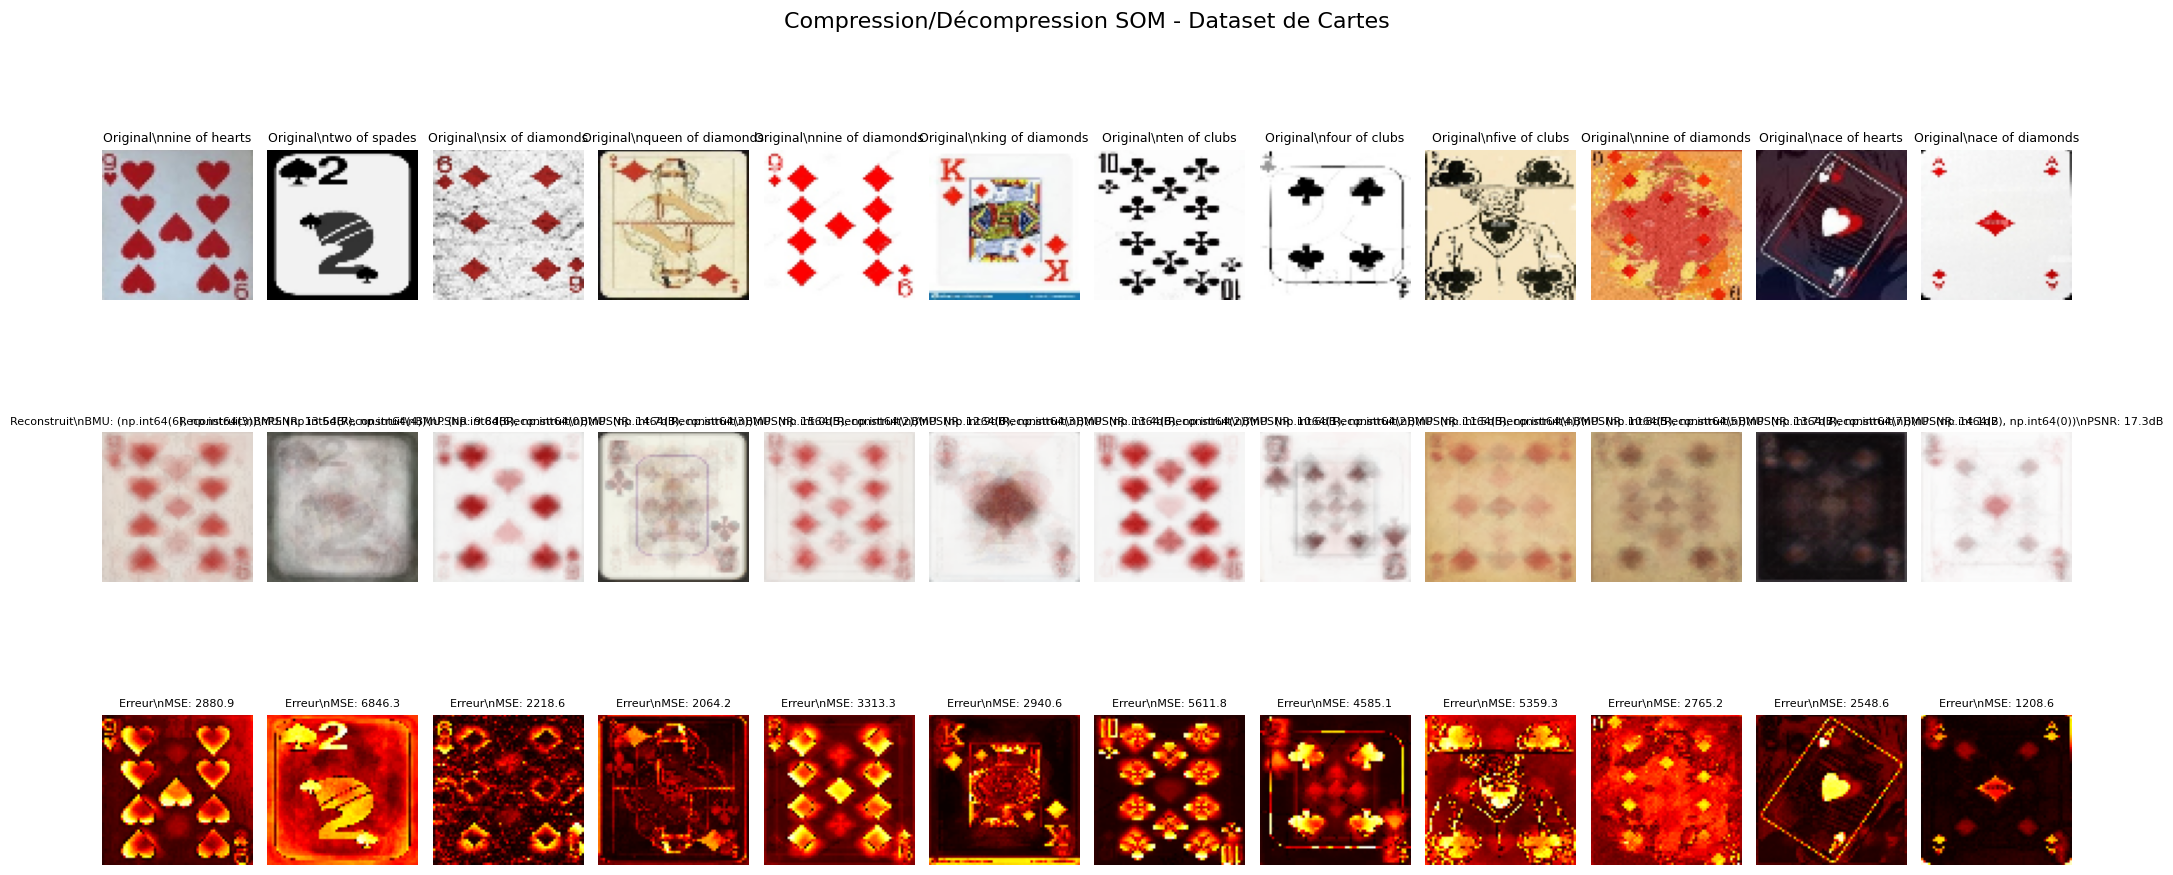

\n5️⃣ Statistiques de compression:
📊 Métriques moyennes:
   - MSE: 3528.5
   - PSNR: 13.1 dB
   - Ratio de compression: 6144.0x
   - Taille originale: 12288 valeurs
   - Taille compressée: 2 coordonnées
\n📍 Coordonnées BMU par classe:
   - nine of hearts: [(np.int64(6), np.int64(3))]
   - two of spades: [(np.int64(7), np.int64(4))]
   - six of diamonds: [(np.int64(6), np.int64(0))]
   - queen of diamonds: [(np.int64(3), np.int64(3))]
   - nine of diamonds: [(np.int64(5), np.int64(2)), (np.int64(5), np.int64(5))]
   - king of diamonds: [(np.int64(0), np.int64(3))]
   - ten of clubs: [(np.int64(6), np.int64(2))]
   - four of clubs: [(np.int64(1), np.int64(2))]
   - five of clubs: [(np.int64(5), np.int64(4))]
   - ace of hearts: [(np.int64(7), np.int64(7))]
   - ace of diamonds: [(np.int64(2), np.int64(0))]
\n🎯 Qualité de reconstruction par classe:
   - nine of hearts: 13.5 dB (moyenne sur 1 échantillons)
   - two of spades: 9.8 dB (moyenne sur 1 échantillons)
   - six of diamonds: 14.7 d

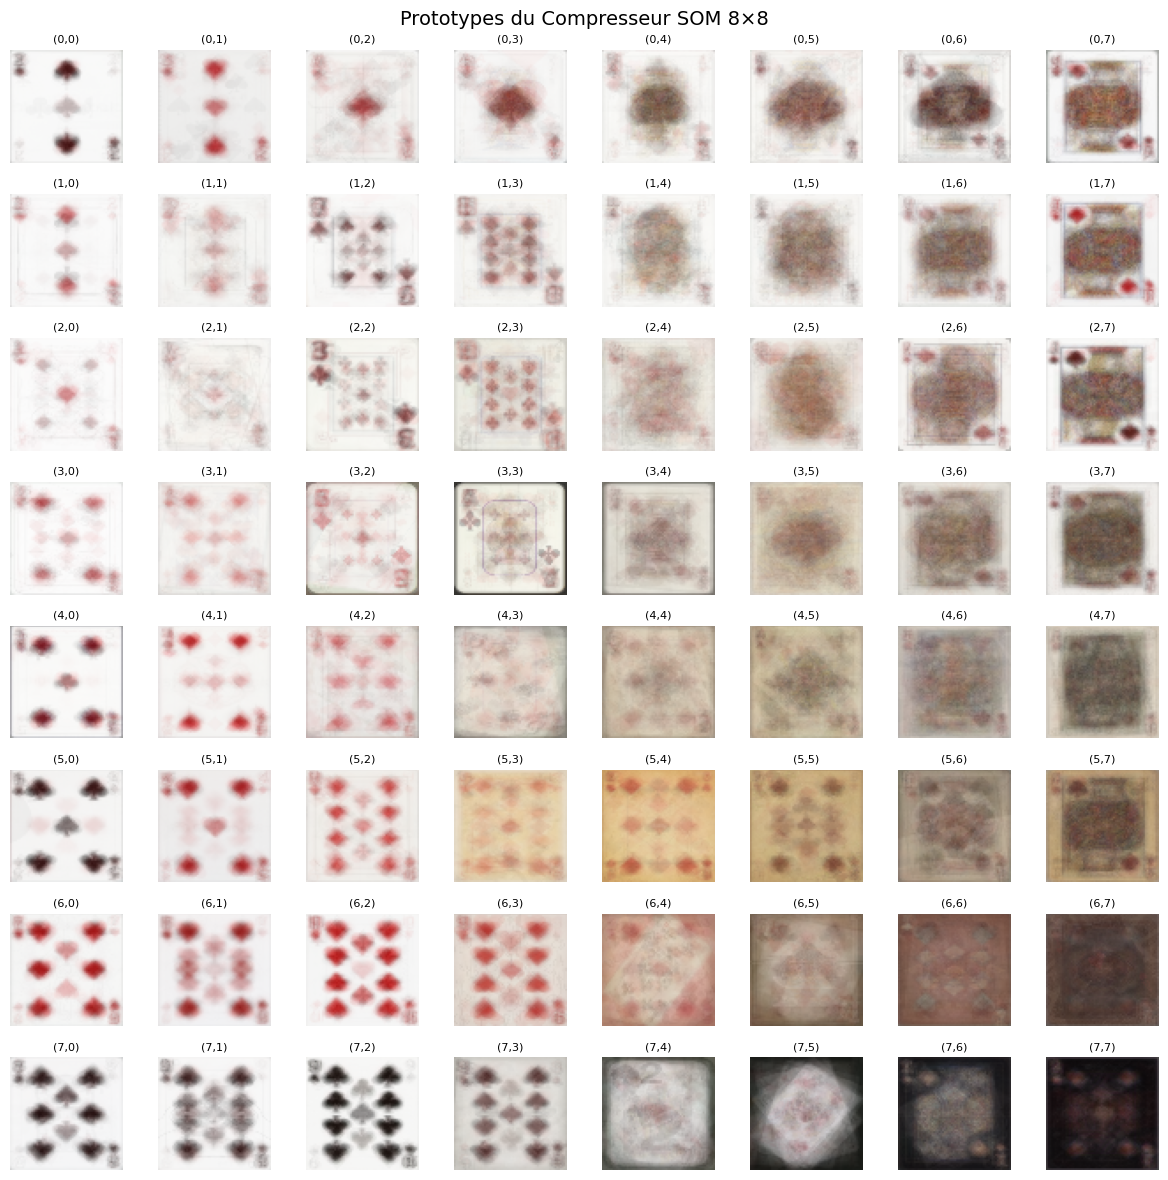

\n✅ Compression SOM terminée!


In [13]:
# Application de SOM_Compressor sur le dataset de cartes
print("=" * 60)
print("🗜️ APPLICATION SOM_COMPRESSOR SUR LE DATASET DE CARTES")
print("=" * 60)

# Vérifier que nous avons des données
if len(card_images) == 0:
    print("❌ Aucune donnée de carte disponible")
else:
    print(f"✅ Données disponibles: {len(card_images)} images de cartes")
    
    # Adapter la classe SOM_Compressor pour les cartes
    class CardSOM_Compressor(SOM_Compressor):
        """
        SOM_Compressor adaptée pour les cartes (64x64x3 → 12288 dimensions)
        """
        def __init__(self, map_size=(10, 10), input_dim=12288):
            super().__init__(map_size, input_dim)
            print(f"🗜️ CardSOM_Compressor initialisé pour les cartes:")
            print(f"   - Dimension d'entrée: {input_dim} (64x64x3)")
            print(f"   - Ratio de compression théorique: {input_dim / 2:.1f}x")
            
        def decompress(self, compressed_coords):
            """
            Décompresse des coordonnées BMU en image de carte
            """
            if not self.is_trained:
                raise ValueError("❌ Compresseur non entraîné!")

            # Récupérer le prototype correspondant
            bmu_i, bmu_j = compressed_coords
            reconstructed_vector = self.prototypes[bmu_i, bmu_j]

            # Reformater en image 64×64×3
            reconstructed_image = reconstructed_vector.reshape(64, 64, 3)
            # S'assurer que les valeurs sont dans la plage [0, 255]
            reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)
            
            return reconstructed_image

    # Préparation des données pour la compression
    print("1️⃣ Préparation des données pour la compression...")
    
    # Utiliser un échantillon pour l'entraînement
    n_training = min(1500, len(card_images))
    training_indices = np.random.choice(len(card_images), n_training, replace=False)
    
    # Préparer les données d'entraînement
    training_cards_flat = []
    for idx in training_indices:
        img = card_images[idx]
        flat_img = img.flatten()
        training_cards_flat.append(flat_img)
    training_cards_flat = np.array(training_cards_flat)
    
    # Préparer les données de test
    test_indices = np.random.choice(len(card_images), 12, replace=False)
    test_images = []
    test_labels = []
    test_classes = []
    
    for idx in test_indices:
        test_images.append(card_images[idx])
        test_labels.append(card_labels[idx])
        test_classes.append(card_dataloader.class_names[card_labels[idx]])
    
    print(f"   - Données d'entraînement: {len(training_cards_flat)} images")
    print(f"   - Données de test: {len(test_images)} images")
    print(f"   - Dimension par image: {training_cards_flat.shape[1]}")
    
    # Création et entraînement du compresseur
    print("\\n2️⃣ Création et entraînement du compresseur...")
    card_compressor = CardSOM_Compressor(map_size=(8, 8), input_dim=12288)
    card_compressor.train(training_cards_flat, epochs=40, verbose=True)
    
    # Compression/décompression des images de test
    print("\\n3️⃣ Compression/décompression des images de test...")
    
    # Aplatir les images de test pour la compression
    test_images_flat = []
    for img in test_images:
        flat_img = img.flatten()
        test_images_flat.append(flat_img)
    
    # Compression/décompression avec images aplaties
    compressed_coords, reconstructed_images, metrics = card_compressor.compress_decompress_batch(test_images_flat)
    
    # Visualisation des résultats
    print("\\n4️⃣ Visualisation des résultats...")
    n_images = len(test_images)
    fig, axes = plt.subplots(3, n_images, figsize=(20, 10))
    
    for i in range(n_images):
        original = test_images[i]
        reconstructed = reconstructed_images[i]
        coords = compressed_coords[i]
        metric = metrics[i]
        class_name = test_classes[i]
        
        # Image originale
        axes[0, i].imshow(original)
        axes[0, i].set_title(f'Original\\n{class_name}', fontsize=9)
        axes[0, i].axis('off')
        
        # Image reconstruite
        axes[1, i].imshow(reconstructed)
        axes[1, i].set_title(f'Reconstruit\\nBMU: {coords}\\nPSNR: {metric["psnr"]:.1f}dB', fontsize=8)
        axes[1, i].axis('off')
        
        # Erreur
        error = np.abs(original.astype(float) - reconstructed.astype(float))
        error_gray = np.mean(error, axis=2)  # Moyenne sur les canaux RGB
        axes[2, i].imshow(error_gray, cmap='hot')
        axes[2, i].set_title(f'Erreur\\nMSE: {metric["mse"]:.1f}', fontsize=8)
        axes[2, i].axis('off')
    
    plt.suptitle('Compression/Décompression SOM - Dataset de Cartes', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Statistiques de compression
    print("\\n5️⃣ Statistiques de compression:")
    print("=" * 50)
    
    avg_mse = np.mean([m['mse'] for m in metrics])
    avg_psnr = np.mean([m['psnr'] for m in metrics])
    compression_ratio = metrics[0]['compression_ratio']
    
    print(f"📊 Métriques moyennes:")
    print(f"   - MSE: {avg_mse:.1f}")
    print(f"   - PSNR: {avg_psnr:.1f} dB")
    print(f"   - Ratio de compression: {compression_ratio:.1f}x")
    print(f"   - Taille originale: {12288} valeurs")
    print(f"   - Taille compressée: 2 coordonnées")
    
    print(f"\\n📍 Coordonnées BMU par classe:")
    class_coords = {}
    for i, coords in enumerate(compressed_coords):
        class_name = test_classes[i]
        if class_name not in class_coords:
            class_coords[class_name] = []
        class_coords[class_name].append(coords)
    
    for class_name, coords_list in class_coords.items():
        print(f"   - {class_name}: {coords_list}")
    
    # Analyse de la qualité par classe
    print(f"\\n🎯 Qualité de reconstruction par classe:")
    class_quality = {}
    for i, class_name in enumerate(test_classes):
        if class_name not in class_quality:
            class_quality[class_name] = []
        class_quality[class_name].append(metrics[i]['psnr'])
    
    for class_name, psnr_list in class_quality.items():
        avg_psnr_class = np.mean(psnr_list)
        print(f"   - {class_name}: {avg_psnr_class:.1f} dB (moyenne sur {len(psnr_list)} échantillons)")
    
    # Visualisation des prototypes du compresseur
    print("\\n6️⃣ Visualisation des prototypes du compresseur...")
    if hasattr(card_compressor, 'prototypes'):
        fig, axes = plt.subplots(card_compressor.map_height, card_compressor.map_width, figsize=(12, 12))
        
        for i in range(card_compressor.map_height):
            for j in range(card_compressor.map_width):
                # Reformater le prototype en image 64×64×3
                prototype_image = card_compressor.prototypes[i, j].reshape(64, 64, 3)
                prototype_image = np.clip(prototype_image / 255.0, 0, 1)
                
                axes[i, j].imshow(prototype_image)
                axes[i, j].set_title(f'({i},{j})', fontsize=8)
                axes[i, j].axis('off')
        
        plt.suptitle('Prototypes du Compresseur SOM 8×8', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    print("\\n✅ Compression SOM terminée!")

🎨 APPLICATION SOM_GENERATOR SUR LE DATASET DE CARTES
✅ Données disponibles: 2650 images de cartes
1️⃣ Préparation des données pour la génération...
🎨 CardSOM_Generator initialisé:
   - Taille originale: (64, 64)
   - Taille de travail: (32, 32)
   - Dimension d'entrée: 3072 (32x32x3)
   - Potentiel de génération: Positions continues dans l'espace 8×8
   - Données d'entraînement: 1000 images
   - Dimension par image prétraitée: 3072
\n2️⃣ Entraînement du générateur...
🏋️ Entraînement du générateur:
   - Échantillons: 1000
   - Époques: 40


Génération: 100%|██████████| 40/40 [00:20<00:00,  1.99it/s]

✅ Générateur entraîné!
\n3️⃣ Techniques de génération synthétique...
   🔄 Interpolation entre positions...
   🎲 Variations autour d'une position...
   🎰 Échantillonnage aléatoire...
   🗺️ Exploration systématique...
   🎯 Génération à partir de vecteurs latents...
\n4️⃣ Visualisation des résultats...


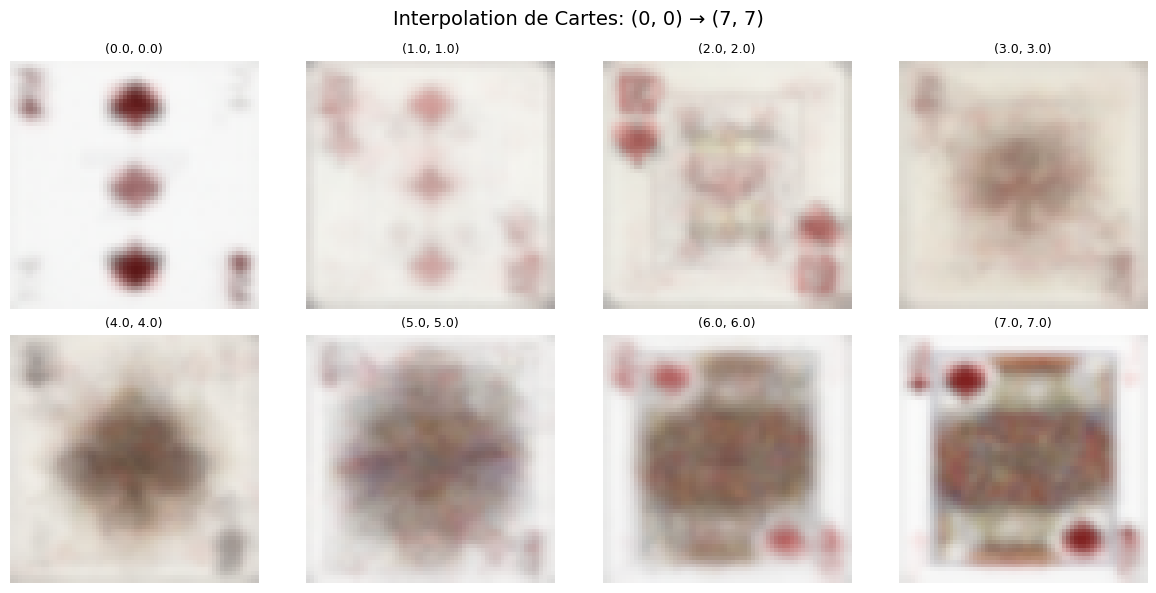

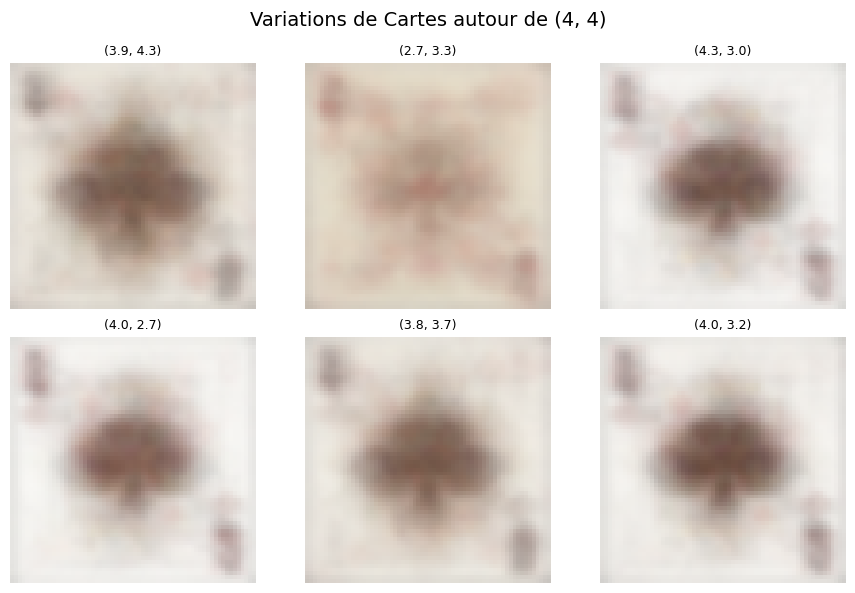

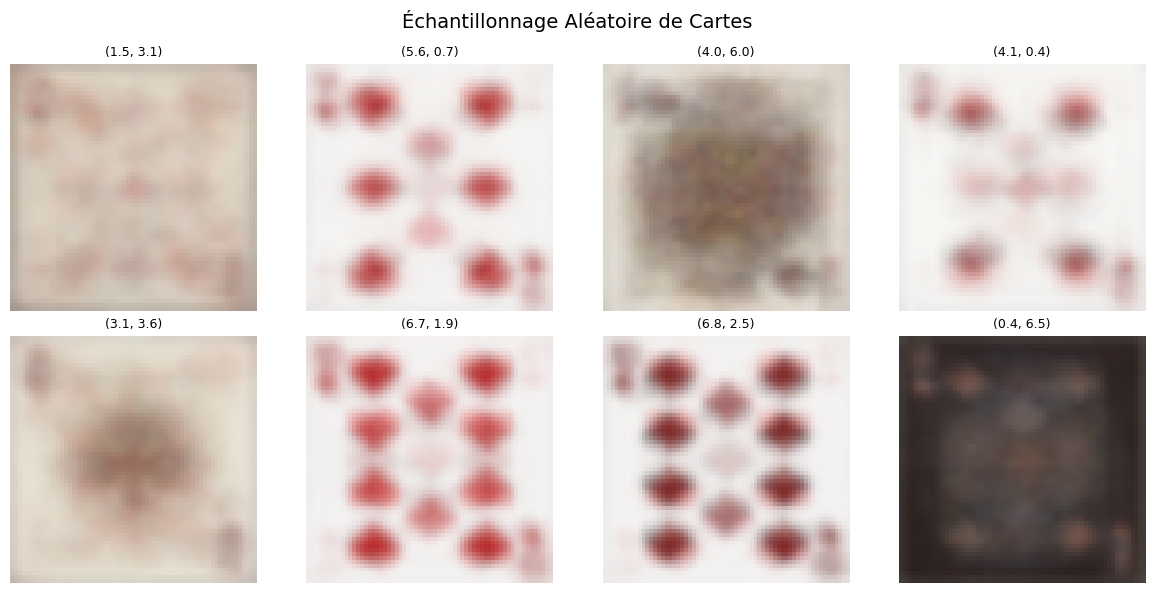

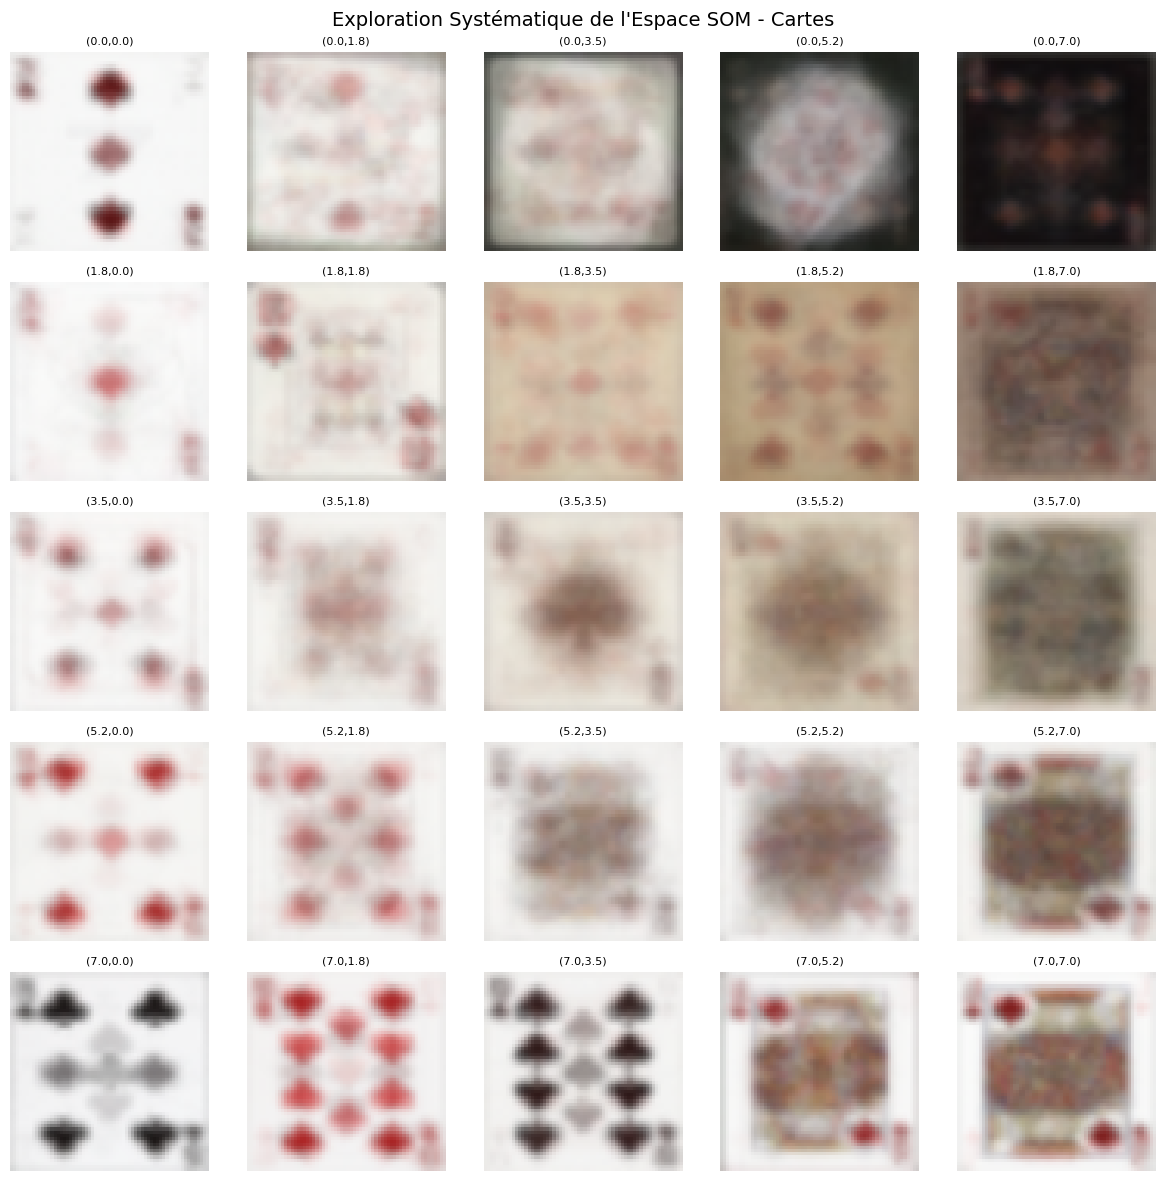

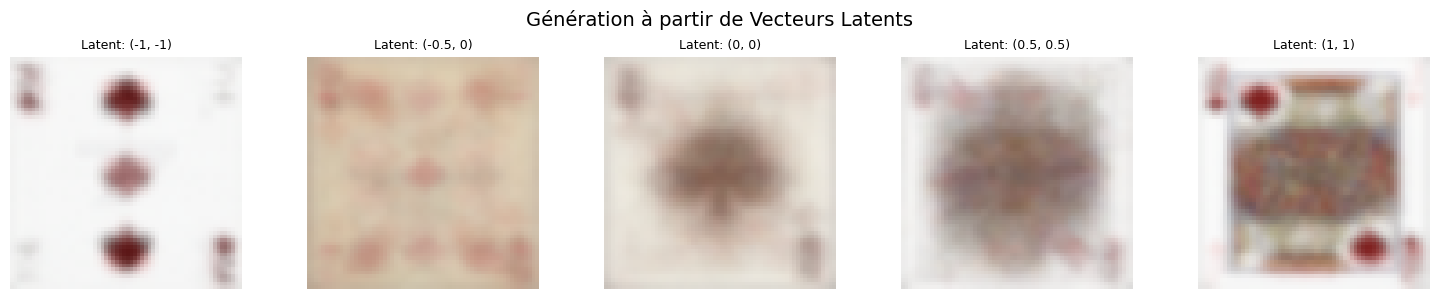

\n5️⃣ Visualisation des prototypes du générateur...


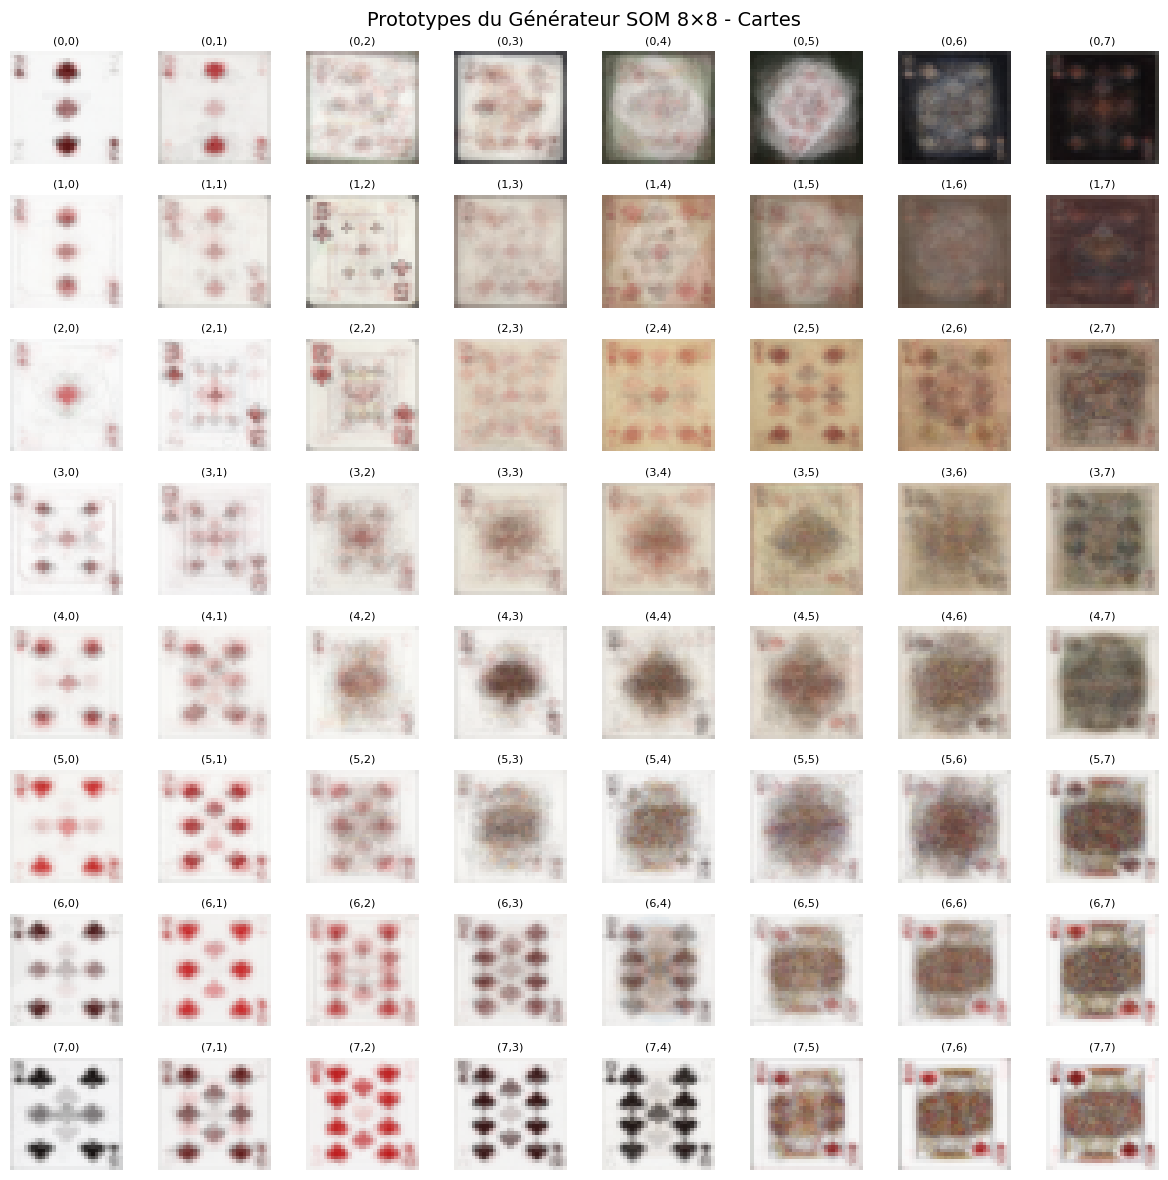

\n6️⃣ Statistiques de génération:
📊 Total d'images de cartes générées: 52
   - Interpolation: 8 images
   - Variations: 6 images
   - Aléatoire: 8 images
   - Exploration: 25 images
   - Latent: 5 images
\n🎯 Techniques de génération maîtrisées:
   ✅ Interpolation bilinéaire entre positions
   ✅ Variations locales autour d'une position
   ✅ Échantillonnage aléatoire dans l'espace SOM
   ✅ Exploration systématique par grille
   ✅ Génération à partir de vecteurs latents
\n🔍 Analyse de la diversité:
   - Espace SOM exploré: 8×8 = 64 positions
   - Possibilités de génération: Continues dans l'espace 8×8
   - Résolution des prototypes: 32×32×3 = 3072 valeurs
\n📈 Comparaison avec les données originales:
   - Images originales: 2650
   - Images générées: 52
   - Augmentation de données: 2.0%
\n✅ Génération SOM terminée!
🎯 Le SOM_Generator a été appliqué avec succès sur le dataset de cartes!
🎨 Les cartes synthétiques peuvent être utilisées pour l'augmentation de données!


In [12]:
# Application de SOM_Generator sur le dataset de cartes
print("=" * 60)
print("🎨 APPLICATION SOM_GENERATOR SUR LE DATASET DE CARTES")
print("=" * 60)

# Vérifier que nous avons des données
if len(card_images) == 0:
    print("❌ Aucune donnée de carte disponible")
else:
    print(f"✅ Données disponibles: {len(card_images)} images de cartes")
    
    # Classe SOM_Generator adaptée pour les cartes
    class CardSOM_Generator:
        """
        SOM_Generator adaptée pour les cartes (64x64x3)
        """
        def __init__(self, map_size=(8, 8), input_dim=3072, original_size=(64, 64)):
            self.map_height, self.map_width = map_size
            self.input_dim = input_dim
            self.original_size = original_size
            self.compressed_size = (32, 32)
            
            # Initialisation des prototypes
            self.prototypes = np.random.uniform(0, 255, (self.map_height, self.map_width, self.input_dim))
            self.is_trained = False
            
            print(f"🎨 CardSOM_Generator initialisé:")
            print(f"   - Taille originale: {original_size}")
            print(f"   - Taille de travail: {self.compressed_size}")
            print(f"   - Dimension d'entrée: {input_dim} (32x32x3)")
            print(f"   - Potentiel de génération: Positions continues dans l'espace {map_size[0]}×{map_size[1]}")
            
        def preprocess_image(self, image):
            """
            Prétraite l'image pour l'entraînement
            """
            # Redimensionner de 64x64 à 32x32
            resized = cv2.resize(image, self.compressed_size)
            return resized.flatten()
            
        def _find_bmu(self, input_vector):
            """Trouve le Best Matching Unit"""
            distances = np.zeros((self.map_height, self.map_width))
            
            for i in range(self.map_height):
                for j in range(self.map_width):
                    diff = self.prototypes[i, j] - input_vector
                    distances[i, j] = np.linalg.norm(diff)
            
            return np.unravel_index(np.argmin(distances), distances.shape)
        
        def _gaussian_neighborhood(self, bmu_pos, sigma):
            """Calcule la fonction de voisinage gaussienne"""
            bmu_i, bmu_j = bmu_pos
            neighborhood = np.zeros((self.map_height, self.map_width))
            
            for i in range(self.map_height):
                for j in range(self.map_width):
                    distance_sq = (i - bmu_i)**2 + (j - bmu_j)**2
                    neighborhood[i, j] = np.exp(-distance_sq / (2 * sigma**2))
            
            return neighborhood
        
        def train(self, training_data, epochs=40, verbose=True):
            """
            Entraîne le générateur SOM
            """
            if verbose:
                print(f"🏋️ Entraînement du générateur:")
                print(f"   - Échantillons: {len(training_data)}")
                print(f"   - Époques: {epochs}")
            
            n_samples = len(training_data)
            initial_learning_rate = 0.1
            initial_sigma = 3.0
            
            progress_bar = tqdm(range(epochs), desc="Génération") if verbose else range(epochs)
            
            for epoch in progress_bar:
                progress = epoch / epochs
                learning_rate = initial_learning_rate * np.exp(-5 * progress)
                sigma = initial_sigma * np.exp(-3 * progress)
                
                indices = np.random.permutation(n_samples)
                for idx in indices:
                    vector = training_data[idx]
                    bmu_pos = self._find_bmu(vector)
                    neighborhood = self._gaussian_neighborhood(bmu_pos, sigma)
                    
                    for i in range(self.map_height):
                        for j in range(self.map_width):
                            influence = learning_rate * neighborhood[i, j]
                            self.prototypes[i, j] += influence * (vector - self.prototypes[i, j])
            
            self.is_trained = True
            if verbose:
                print(f"✅ Générateur entraîné!")
        
        def _bilinear_interpolation(self, float_i, float_j):
            """
            Interpolation bilinéaire pour positions continues
            """
            # Coordonnées des 4 voisins
            i_low, i_high = int(np.floor(float_i)), int(np.ceil(float_i))
            j_low, j_high = int(np.floor(float_j)), int(np.ceil(float_j))
            
            # Limites de la carte
            i_low = max(0, min(i_low, self.map_height - 1))
            i_high = max(0, min(i_high, self.map_height - 1))
            j_low = max(0, min(j_low, self.map_width - 1))
            j_high = max(0, min(j_high, self.map_width - 1))
            
            # Poids d'interpolation
            w_i = float_i - i_low
            w_j = float_j - j_low
            
            # Interpolation bilinéaire
            top_left = self.prototypes[i_low, j_low]
            top_right = self.prototypes[i_low, j_high]
            bottom_left = self.prototypes[i_high, j_low]
            bottom_right = self.prototypes[i_high, j_high]
            
            top = (1 - w_j) * top_left + w_j * top_right
            bottom = (1 - w_j) * bottom_left + w_j * bottom_right
            
            result = (1 - w_i) * top + w_i * bottom
            return result
            
        def generate_from_position(self, position):
            """
            Génère une image de carte à partir d'une position dans la carte SOM
            """
            if not self.is_trained:
                raise ValueError("❌ Générateur non entraîné!")

            i, j = position

            # Position discrète
            if i == int(i) and j == int(j):
                synthetic_vector = self.prototypes[int(i), int(j)]
            else:
                # Position continue - interpolation
                synthetic_vector = self._bilinear_interpolation(i, j)

            # Reformater en image 32×32×3
            synthetic_32 = synthetic_vector.reshape(32, 32, 3)
            synthetic_32 = np.clip(synthetic_32, 0, 255).astype(np.uint8)
            
            # Redimensionner vers la taille originale
            synthetic_image = cv2.resize(synthetic_32, self.original_size)
            
            return synthetic_image
        
        def interpolate_between_positions(self, pos1, pos2, num_steps=8):
            """
            Interpole entre deux positions dans la carte SOM
            """
            if not self.is_trained:
                raise ValueError("❌ Générateur non entraîné!")

            i1, j1 = pos1
            i2, j2 = pos2

            interpolated_images = []
            interpolated_positions = []

            for step in range(num_steps):
                alpha = step / (num_steps - 1) if num_steps > 1 else 0

                pos_interp = (
                    i1 + alpha * (i2 - i1),
                    j1 + alpha * (j2 - j1)
                )

                synthetic_image = self.generate_from_position(pos_interp)
                interpolated_images.append(synthetic_image)
                interpolated_positions.append(pos_interp)

            return interpolated_images, interpolated_positions
        
        def generate_variations(self, center_position, radius=1.0, num_variations=6):
            """
            Génère des variations autour d'une position centrale
            """
            if not self.is_trained:
                raise ValueError("❌ Générateur non entraîné!")

            center_i, center_j = center_position
            variations = []
            positions = []

            for _ in range(num_variations):
                # Angle et distance aléatoires
                angle = np.random.uniform(0, 2 * np.pi)
                distance = np.random.uniform(0, radius)

                # Nouvelle position
                new_i = center_i + distance * np.cos(angle)
                new_j = center_j + distance * np.sin(angle)

                # Limites
                new_i = max(0, min(new_i, self.map_height - 1))
                new_j = max(0, min(new_j, self.map_width - 1))

                pos = (new_i, new_j)
                positions.append(pos)

                synthetic_image = self.generate_from_position(pos)
                variations.append(synthetic_image)

            return variations, positions
        
        def generate_random_samples(self, num_samples=8):
            """
            Génère des échantillons aléatoires dans l'espace SOM
            """
            if not self.is_trained:
                raise ValueError("❌ Générateur non entraîné!")

            random_samples = []
            random_positions = []

            for _ in range(num_samples):
                # Position aléatoire
                random_i = np.random.uniform(0, self.map_height - 1)
                random_j = np.random.uniform(0, self.map_width - 1)

                pos = (random_i, random_j)
                random_positions.append(pos)

                synthetic_image = self.generate_from_position(pos)
                random_samples.append(synthetic_image)

            return random_samples, random_positions
        
        def explore_grid(self, grid_resolution=5):
            """
            Explore systématiquement l'espace SOM avec une grille
            """
            if not self.is_trained:
                raise ValueError("❌ Générateur non entraîné!")

            # Positions de la grille
            i_positions = np.linspace(0, self.map_height - 1, grid_resolution)
            j_positions = np.linspace(0, self.map_width - 1, grid_resolution)

            exploration_grid = np.zeros((grid_resolution, grid_resolution, 64, 64, 3))
            position_grid = np.zeros((grid_resolution, grid_resolution, 2))

            for i_idx, i_pos in enumerate(i_positions):
                for j_idx, j_pos in enumerate(j_positions):
                    pos = (i_pos, j_pos)
                    synthetic_image = self.generate_from_position(pos)

                    exploration_grid[i_idx, j_idx] = synthetic_image
                    position_grid[i_idx, j_idx] = [i_pos, j_pos]

            return exploration_grid, position_grid
        
        def generate_from_latent(self, latent_vector, latent_range=(-1, 1)):
            """
            Génère une image à partir d'un vecteur latent dans un espace ℝ²
            """
            if not self.is_trained:
                raise ValueError("❌ Générateur non entraîné!")

            x, y = latent_vector
            latent_min, latent_max = latent_range

            # Normalisation du vecteur latent vers la grille SOM
            norm_x = (x - latent_min) / (latent_max - latent_min) * (self.map_height - 1)
            norm_y = (y - latent_min) / (latent_max - latent_min) * (self.map_width - 1)

            return self.generate_from_position((norm_x, norm_y))

    # Préparation des données pour la génération
    print("1️⃣ Préparation des données pour la génération...")
    
    # Utiliser un échantillon pour l'entraînement
    n_training = min(1000, len(card_images))
    training_indices = np.random.choice(len(card_images), n_training, replace=False)
    
    # Créer le générateur
    card_generator = CardSOM_Generator(map_size=(8, 8), input_dim=3072)
    
    # Préparer les données d'entraînement (prétraitées)
    training_cards_preprocessed = []
    for idx in training_indices:
        img = card_images[idx]
        preprocessed = card_generator.preprocess_image(img)
        training_cards_preprocessed.append(preprocessed)
    training_cards_preprocessed = np.array(training_cards_preprocessed)
    
    print(f"   - Données d'entraînement: {len(training_cards_preprocessed)} images")
    print(f"   - Dimension par image prétraitée: {training_cards_preprocessed.shape[1]}")
    
    # Entraînement du générateur
    print("\\n2️⃣ Entraînement du générateur...")
    card_generator.train(training_cards_preprocessed, epochs=40, verbose=True)
    
    # Techniques de génération
    print("\\n3️⃣ Techniques de génération synthétique...")
    
    # Technique 1: Interpolation entre positions
    print("   🔄 Interpolation entre positions...")
    pos1, pos2 = (0, 0), (7, 7)
    interpolated_images, interpolated_positions = card_generator.interpolate_between_positions(pos1, pos2, num_steps=8)
    
    # Technique 2: Variations autour d'une position
    print("   🎲 Variations autour d'une position...")
    center_pos = (4, 4)
    variations, var_positions = card_generator.generate_variations(center_pos, radius=2.0, num_variations=6)
    
    # Technique 3: Échantillonnage aléatoire
    print("   🎰 Échantillonnage aléatoire...")
    random_samples, random_positions = card_generator.generate_random_samples(num_samples=8)
    
    # Technique 4: Exploration systématique
    print("   🗺️ Exploration systématique...")
    exploration_grid, position_grid = card_generator.explore_grid(grid_resolution=5)
    
    # Technique 5: Génération à partir de vecteurs latents
    print("   🎯 Génération à partir de vecteurs latents...")
    latent_samples = [(-1, -1), (-0.5, 0), (0, 0), (0.5, 0.5), (1, 1)]
    latent_generated = []
    for latent in latent_samples:
        generated_img = card_generator.generate_from_latent(latent)
        latent_generated.append(generated_img)
    
    # Visualisation des résultats
    print("\\n4️⃣ Visualisation des résultats...")
    
    # Interpolation
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        row, col = i // 4, i % 4
        axes[row, col].imshow(interpolated_images[i])
        pos = interpolated_positions[i]
        axes[row, col].set_title(f'({pos[0]:.1f}, {pos[1]:.1f})', fontsize=9)
        axes[row, col].axis('off')
    plt.suptitle(f'Interpolation de Cartes: {pos1} → {pos2}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Variations
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))
    for i in range(6):
        row, col = i // 3, i % 3
        axes[row, col].imshow(variations[i])
        pos = var_positions[i]
        axes[row, col].set_title(f'({pos[0]:.1f}, {pos[1]:.1f})', fontsize=9)
        axes[row, col].axis('off')
    plt.suptitle(f'Variations de Cartes autour de {center_pos}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Échantillonnage aléatoire
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        row, col = i // 4, i % 4
        axes[row, col].imshow(random_samples[i])
        pos = random_positions[i]
        axes[row, col].set_title(f'({pos[0]:.1f}, {pos[1]:.1f})', fontsize=9)
        axes[row, col].axis('off')
    plt.suptitle('Échantillonnage Aléatoire de Cartes', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Exploration systématique
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(exploration_grid[i, j].astype(np.uint8))
            pos = position_grid[i, j]
            axes[i, j].set_title(f'({pos[0]:.1f},{pos[1]:.1f})', fontsize=8)
            axes[i, j].axis('off')
    plt.suptitle('Exploration Systématique de l\'Espace SOM - Cartes', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Génération à partir de vecteurs latents
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, (latent, img) in enumerate(zip(latent_samples, latent_generated)):
        axes[i].imshow(img)
        axes[i].set_title(f'Latent: {latent}', fontsize=9)
        axes[i].axis('off')
    plt.suptitle('Génération à partir de Vecteurs Latents', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Visualisation des prototypes du générateur
    print("\\n5️⃣ Visualisation des prototypes du générateur...")
    fig, axes = plt.subplots(card_generator.map_height, card_generator.map_width, figsize=(12, 12))
    
    for i in range(card_generator.map_height):
        for j in range(card_generator.map_width):
            # Reformater le prototype en image 32×32×3
            prototype_image = card_generator.prototypes[i, j].reshape(32, 32, 3)
            prototype_image = np.clip(prototype_image / 255.0, 0, 1)
            
            axes[i, j].imshow(prototype_image)
            axes[i, j].set_title(f'({i},{j})', fontsize=8)
            axes[i, j].axis('off')
    
    plt.suptitle('Prototypes du Générateur SOM 8×8 - Cartes', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Statistiques de génération
    print("\\n6️⃣ Statistiques de génération:")
    print("=" * 50)
    
    total_generated = len(interpolated_images) + len(variations) + len(random_samples) + (5 * 5) + len(latent_generated)
    print(f"📊 Total d'images de cartes générées: {total_generated}")
    print(f"   - Interpolation: {len(interpolated_images)} images")
    print(f"   - Variations: {len(variations)} images")
    print(f"   - Aléatoire: {len(random_samples)} images")
    print(f"   - Exploration: {5 * 5} images")
    print(f"   - Latent: {len(latent_generated)} images")
    
    print(f"\\n🎯 Techniques de génération maîtrisées:")
    print(f"   ✅ Interpolation bilinéaire entre positions")
    print(f"   ✅ Variations locales autour d'une position")
    print(f"   ✅ Échantillonnage aléatoire dans l'espace SOM")
    print(f"   ✅ Exploration systématique par grille")
    print(f"   ✅ Génération à partir de vecteurs latents")
    
    # Analyse de la diversité des cartes générées
    print(f"\\n🔍 Analyse de la diversité:")
    print(f"   - Espace SOM exploré: {card_generator.map_height}×{card_generator.map_width} = {card_generator.map_height * card_generator.map_width} positions")
    print(f"   - Possibilités de génération: Continues dans l'espace 8×8")
    print(f"   - Résolution des prototypes: 32×32×3 = {32*32*3} valeurs")
    
    # Comparaison avec les données originales
    print(f"\\n📈 Comparaison avec les données originales:")
    print(f"   - Images originales: {len(card_images)}")
    print(f"   - Images générées: {total_generated}")
    print(f"   - Augmentation de données: {total_generated / len(card_images) * 100:.1f}%")
    
    print("\\n✅ Génération SOM terminée!")
    print("🎯 Le SOM_Generator a été appliqué avec succès sur le dataset de cartes!")
    print("🎨 Les cartes synthétiques peuvent être utilisées pour l'augmentation de données!")